In [1]:
import numpy as np
import matplotlib.pyplot as mt
from scipy.linalg import eigh_tridiagonal
import time

#Funciones utilizadas------------------------------------

#Diagonalización de matrices tridiagonales
def diagonalizar_tridiagonal_simetrica(diagonal_principal, diagonal_superior):
    # Calcular autovalores y autovectores
    autovalores, autovectores = eigh_tridiagonal(diagonal_principal, diagonal_superior, eigvals_only=False)
    return autovalores,autovectores

#Medir tiempo
start_time = time.time()
end_time = time.time()
execution_time = end_time - start_time
print(f"El tiempo de ejecución fue: {execution_time:.6f} segundos")

El tiempo de ejecución fue: 0.000323 segundos


In [2]:
#Todas las funciones utilizadas

#Representacion de M frente a E----------------------------------
def diagrama_de_fases(h,K,N):
    s=1/2#Spin individual
    S=int(N*s)#Spin total
    Ms=np.arange(S, -S - 1, -1)
    Ms=Ms.astype(float)
    #Matriz S_z----------------
    S_z=np.diag(Ms)
    #Matriz S_+----------------

    def s_mas(m):
        return np.sqrt(S*(S+1)-m*(m+1))

    S_mas = np.zeros((2*S+1, 2*S+1))
    s_mas_vector= s_mas(np.arange(S-1, -S - 1, -1))

    for i in range(len(s_mas_vector)):
        S_mas[i, i + 1] = s_mas_vector[i]
    #Matriz S_- -------------    

    def s_menos(m):
        return np.sqrt(S*(S+1)-m*(m-1))

    S_menos = np.zeros((2*S+1, 2*S+1))
    s_menos_vector= s_menos(np.arange(S, -S, -1))
    for i in range(len(s_menos_vector)):
        S_menos[i+1, i] = s_menos_vector[i]
    #Matriz S_x

    S_x=1/2 * (S_mas + S_menos)
    J=1
    epsilon=10**(-6)
    H=-(4*J)/N * np.diag(Ms*Ms)-2*h*S_x-(16*K)/(N**3)*np.diag(Ms*Ms*Ms*Ms) + epsilon*S_z

    #Obtenemos las autoenergías diagonalizando la matriz:
    autoenergias, autovectores = diagonalizar_tridiagonal_simetrica(np.diag(H), np.diag(H, k=1))
    magn=[]
    for i in range(int(N+1)):
        magn.append((autovectores[:,i] @ (Ms*autovectores[:,i]).T)*1/(N/2))  
    #Representación del valor promedio de S_z frente a las energías obtenidas
    #mt.plot(autoenergias/(N/2),np.array(magn),'.')
    #mt.axhline(y=1,color='red',label="$S_{max}$")
    #mt.axhline(y=-1,color='green',label="$S_{min}$")
    #mt.xlabel("$E_{n}$")
    #mt.ylabel("M")
    #mt.title(f'h={h} K={K}')
    #mt.legend()
    #mt.grid()
    
    return autoenergias/(N),np.array(magn)



#Magnetización en el estado fundamental----------------------------------

def Mf(N,h,K):
    s=1/2#Spin individual
    S=int(N*s)#Spin total
    Ms=np.arange(S, -S - 1, -1)
    Ms=Ms.astype(float)
    #Matriz S_z----------------
    S_z=np.diag(Ms)
    #Matriz S_+----------------

    def s_mas(m):
        return np.sqrt(S*(S+1)-m*(m+1))

    S_mas = np.zeros((2*S+1, 2*S+1))
    s_mas_vector= s_mas(np.arange(S-1, -S - 1, -1))

    for i in range(len(s_mas_vector)):
        S_mas[i, i + 1] = s_mas_vector[i]
    #Matriz S_- -------------    

    def s_menos(m):
        return np.sqrt(S*(S+1)-m*(m-1))

    S_menos = np.zeros((2*S+1, 2*S+1))
    s_menos_vector= s_menos(np.arange(S, -S, -1))
    for i in range(len(s_menos_vector)):
        S_menos[i+1, i] = s_menos_vector[i]
    #Matriz S_x

    S_x=1/2 * (S_mas + S_menos)
    J=1
    epsilon=10**(-6)
    H=-(4*J)/N * np.diag(Ms*Ms)-2*h*S_x-(16*K)/(N**3)*np.diag(Ms*Ms*Ms*Ms) + epsilon*S_z

    #Obtenemos las autoenergías diagonalizando la matriz:
    autoenergias, autovectores = diagonalizar_tridiagonal_simetrica(np.diag(H), np.diag(H, k=1))
    M=autovectores[:,0] @ (Ms*autovectores[:,0]).T*1/(N/2)
    return np.abs(M)
Mf_vect=np.vectorize(Mf)


#Ev temporal cuántica------------------------------------

import matplotlib.pyplot as plt
def evolution_time(h0, hf,K0, Kf, eps0, eps1, t0, tf, p, N):
    energ1, auto1 = energ_estados(N, h0, K0, eps0)
    energ2, auto2 = energ_estados(N, hf, Kf, eps1)

    # Cambio de base
    U = auto2.T @ auto1

    # Estado inicial
    c = np.zeros((N + 1, 1))
    c[0] = 1
    d = U @ c

    # Precalculos
    s = 0.5
    S = int(N * s)
    Ms = np.arange(S, -S - 1, -1)
    sz_matrix = np.tensordot(auto2.T, (Ms[:, None] * auto2), axes=([1], [0]))

    # Cálculo de S_z en función del tiempo
    energy_diff = energ2[:, None] - energ2[None, :]
    d_d_conj = np.outer(np.conjugate(d[:, 0]), d[:, 0])

    tp = np.linspace(t0, tf, p)
    S_zm = [
        np.sum(sz_matrix * np.exp(-1j * energy_diff * t) * d_d_conj).real / (N / 2)
        for t in tp
    ]

    plt.plot(tp, S_zm)
    plt.xlabel("t")
    plt.ylabel("M")
    plt.title(f"h0={h0} hf={hf} K0={K0} Kf={Kf} eps0={eps0} epsf={eps1}")
    plt.show()


def energ_estados(N, h,K, eps):
    s = 0.5
    S = int(N * s)
    Ms = np.arange(S, -S - 1, -1)

    # Matriz S_z
    S_z = np.diag(Ms)

    def s_mas(m):
        return np.sqrt(S*(S+1)-m*(m+1))

    S_mas = np.zeros((2*S+1, 2*S+1))
    s_mas_vector= s_mas(np.arange(S-1, -S - 1, -1))

    for i in range(len(s_mas_vector)):
        S_mas[i, i + 1] = s_mas_vector[i]
    #Matriz S_- -------------    

    def s_menos(m):
        return np.sqrt(S*(S+1)-m*(m-1))

    S_menos = np.zeros((2*S+1, 2*S+1))
    s_menos_vector= s_menos(np.arange(S, -S, -1))
    for i in range(len(s_menos_vector)):
        S_menos[i+1, i] = s_menos_vector[i]
    #Matriz S_x
    S_x=1/2 * (S_mas + S_menos)

    # Hamiltoniano
    J = 1
    H = -(4 * J) / N * np.diag(Ms**2) - 2 * h * S_x + eps * S_z -(16*K)/(N**3)*np.diag(Ms*Ms*Ms*Ms)

    # Diagonalización
    autoenergias, autovectores = np.linalg.eigh(H)
    return autoenergias, autovectores


#Distribución de energías----------------------------------------------------
def distribucion_energias(N,h0,hf,K0,Kf,eps0,eps1):
    s = 0.5
    S = int(N * s)
    Ms = np.arange(S, -S - 1, -1)
#Autovalores y autoestados en ambos hamiltonianos
    energ1, auto1 = energ_estados(N, h0,K0, eps0)
    energ2, auto2 = energ_estados(N, hf,Kf, eps1)

# Cambio de base
    U = auto2.T @ auto1

# Estado inicial
    c = np.zeros((N + 1, 1))
    c[0] = 1
    d = U @ c
    prob=np.abs(d)**2

#Magnetización
    magn=[]
    for i in range(int(N+1)):
        magn.append((auto2[:,i] @ (Ms*auto2[:,i]).T)*1/(N/2))


    plt.plot(magn,prob,'.')
    plt.xlabel(r"$M$")
    plt.ylabel("Probability")
    plt.title(f"h0={h0} hf={hf} K0={K0} Kf={Kf} eps0={eps0} epsf={eps1}")
    plt.grid()
    plt.show()
    print(f"La máxima probabilidad se da para M = {magn[np.argmax(prob)]}")
    
    plt.plot(energ2/(N/2),prob,'.')
    plt.xlabel(r"$E_{n}$")
    plt.ylabel("Probability")
    plt.title(f"h0={h0} hf={hf} K0={K0} Kf={Kf} eps0={eps0} epsf={eps1}")
    plt.grid()
    
    print(f"La máxima probabilidad se da para E_n = {energ2[np.argmax(prob)]/(N/2)}")


    return

# SISTEMA CUÁNTICO

Para comenzar, realizaremos una comparación de la energía obtenida a través de un análisis siguiendo la física estadística cuántica en el límite termodinámico, con la obtenida a través del mismo hamiltoniano pero analizado mediante mecánica clásica; esto último es dejando nuestro hamiltoniano en función de las coordenadas y momentos conjugados generalizado, esto es, utilizando su relación con las variables J_z y J_x del sistema en su conjunto. Según la ecuación (17) del artículo [1], la energía tiene la forma:

\begin{equation}
    \epsilon(m_{z},J,h,K) = -J m_{z}^{2} - K m_{z}^{4} - h \sqrt{1-m_{z}^{2}}
\end{equation}

En función de los parámetros J, h y K la estructura de la energía será distinta, como consecuencia el mínimo de la misma (estado fundamental) se situará en distintos puntos. Se distinguen de aquí tres casos, que se visualizan mejor utilizando la serie de Maclaurin, es decir, desarrollando en Taylor esta expresión en torno a $m_{z}=0$. La expresión queda:

\begin{equation}
    \epsilon(m_{z},J,h,K) \approx -h +(\frac{h}{2}-J) m_{z}^{2} + (\frac{h}{8}-K)m_{z}^{4} + O(m_{z}^{6})
\end{equation}

Para distintos valores de h, J y K los signos de los términos de orden 2 y 4 varían, y con ellos número y la altura de los mínimos de la función dando lugar a diferentes estados fundamentales y a transiciones entre ellos.

1. Para un término de orden 4 positivo, es decir, $\frac{h}{8}>K$, observamos un punto crítico en $h_{c}$=2J que cambia el signo del término de orden 2 y como consecuencia separa una región ferromagnética ($<M> \neq 0$) para h<2J de otra paramagnética($<M> = 0$) para h>2J. Esta transición es de segundo orden, algo que se observa como un cambio suave del mínimo según varía h de una zona a la otra y se comprobará en la simulación posteriormente como el cambio de la magnetización de manera analítica.
2. Otra transición, esta vez de primer orden dado el cambio repentino de la magnetización y una variación brusca del mínimo de energía del sistema, aparece en la región h>2J, ahora con el cambio de signo del término de cuarto orden. Esta transición no aparece en un hamiltoniano sin el término de interacción entre spines en grupos de 4. Aquí tenemos entonces una línea crítica, puesto que no es un único valor de K, sino que para cada h existe un $K_{c}$ a partir del cual ocurre esta transición de ferromagnético a paramagnético. Representando las energías se observa de la siguiente manera con J=1:

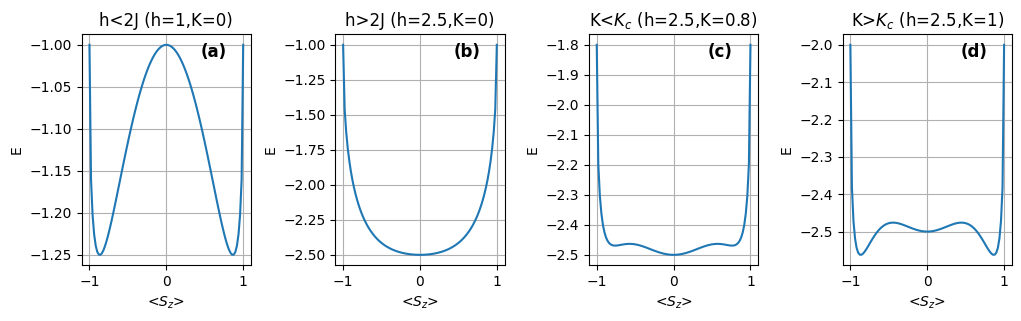

In [5]:
x=np.linspace(-1,1,100)
fig, axes = mt.subplots(1, 4, figsize=(12, 3))
fig.subplots_adjust(wspace=0.5)
axes[0].set_title("h<2J (h=1,K=0)")
axes[0].set_xlabel("<$S_z$>")
axes[0].set_ylabel("E")
axes[0].plot(x,-1*x**2-0*x**4-1*np.sqrt(1-x**2))
axes[0].text(0.7, 0.9, "(a)", transform=axes[0].transAxes, fontsize=12, fontweight='bold')
axes[0].grid()
axes[1].set_title("h>2J (h=2.5,K=0)")
axes[1].set_xlabel("<$S_z$>")
axes[1].set_ylabel("E")
axes[1].plot(x,-1*x**2-0*x**4-2.5*np.sqrt(1-x**2))
axes[1].text(0.7, 0.9, "(b)", transform=axes[1].transAxes, fontsize=12, fontweight='bold')
axes[1].grid()
axes[2].set_title("K<$K_{c}$ (h=2.5,K=0.8)")
axes[2].set_xlabel("<$S_z$>")
axes[2].set_ylabel("E")
axes[2].plot(x,-1*x**2-0.8*x**4-2.5*np.sqrt(1-x**2))
axes[2].text(0.7, 0.9, "(c)", transform=axes[2].transAxes, fontsize=12, fontweight='bold')
axes[2].grid()
axes[3].set_title("K>$K_{c}$ (h=2.5,K=1)")
axes[3].set_xlabel("<$S_z$>")
axes[3].set_ylabel("E")
axes[3].plot(x,-1*x**2-1*x**4-2.5*np.sqrt(1-x**2))
axes[3].text(0.7, 0.9, "(d)", transform=axes[3].transAxes, fontsize=12, fontweight='bold')
axes[3].grid()
mt.show()

La expresión de esta línea de primer orden podemos aproximarla para valores próximos al punto crítico a la transición de segundo orden en $h_{c}=2J$ obteniendo la siguiente expresión:
\begin{equation}
    K_{c}^{approx}=\frac{h}{8}+\frac{1}{2} \sqrt{\frac{h(h-2)}{2}}
\end{equation}
Sin embargo la expresión exacta de Mathematica está dada por:
\begin{equation}
    K_{c}^{exact} = \frac{1}{64h} \bigl[27 h^{2}-36h-4+\sqrt{(9h-2)^{3}(h-2)}\bigr]
\end{equation}

Utilizando toda esta información podemos representar en un diagrama el estado fundamental que nos encontraremos en función de h/J y K/J:

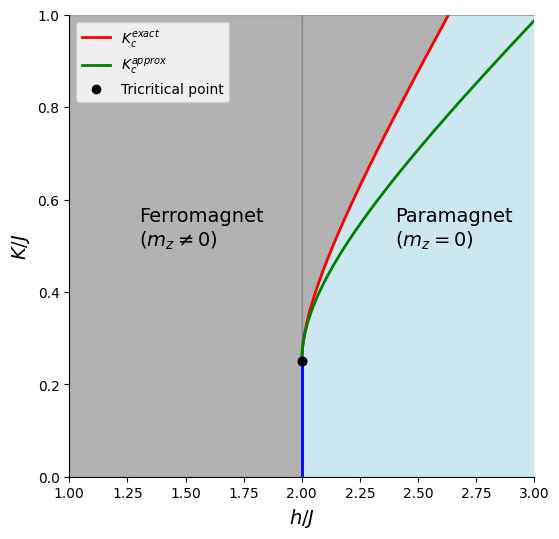

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Definir la ecuación de K_c^R
def K_c_R(h):
    return (1 / (64 * h)) * (27 * h**2 - 36 * h - 4 + np.sqrt((9 * h - 2)**3 * (h - 2)))
def K_c_D(h):
    return h/8 + (1/2)*np.sqrt((h*(h-2))/2)

# Rango de valores para h
h_values = np.linspace(2.0, 3.0, 300)
K_values = K_c_R(h_values)
K_values2 = K_c_D(h_values)
# Crear la figura y ejes
fig, ax = plt.subplots(figsize=(6, 6))

# Colorear las regiones correctamente
ax.fill_between([1.0, 2.0], 0, 1.0, color="gray", alpha=0.6)  # Ferromagnetismo
ax.fill_between(h_values, 0, K_values, color="lightblue", alpha=0.6)  # Extensión del ferromagnetismo
ax.fill_between(h_values, K_values, 1.0, color="gray", alpha=0.6)  # Paramagnetismo

# Graficar la línea roja K_c^R
ax.plot(h_values, K_values, 'r-', linewidth=2,label="$K_{c}^{exact}$")
ax.plot(h_values, K_values2, '-', linewidth=2,label="$K_{c}^{approx}$",color="green")
# Punto crítico
h_crit = 2.0
K_crit = K_c_R(h_crit)
ax.plot(h_crit, K_crit, 'bo', markersize=6)  # Punto azul
ax.plot([h_crit, h_crit], [0, K_crit], 'b-', linewidth=2)  # Línea azul vertical


ax.plot(2, 1/4, 'ko', markersize=6, label="Tricritical point")

# Etiquetas y formato
ax.set_xlabel(r"$h/J$", fontsize=14)
ax.set_ylabel(r"$K/J$", fontsize=14)
ax.set_xlim(1.0, 3.0)
ax.set_ylim(0, 1.0)

# Etiquetas de las regiones
ax.text(1.3, 0.5, r"Ferromagnet" "\n" r"$(m_z \neq 0)$", fontsize=14, color="black")
ax.text(2.4, 0.5, r"Paramagnet" "\n" r"$(m_z = 0)$", fontsize=14, color="black")

# Ajustar estilo de los ejes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()
plt.show()



Aquí de manera más visual se muestra el estado fundamental que tenemos en función de los parámetros. También se representa la línea crítica de primer orden exacta $K_{c}^{exact}$ y la aproximada $K_{c}^{approx}$.

La simulación del sistema se comenzó definiendo los operadores $S_{z}$ y $S_{x}$. Para ello, utilizamos la conmutatividad del operador spin total del sistema $\boldsymbol{S^{2}}$ para descomponer el espacio de Hilbert en un conjunto de subespacios con spin total fijado con valor S=0,1,...,N/2 que provienen del acoplamiento de los N spines. Dentro de estos, escogemos un subespacio representativo de los demás (no tengo claro porqué este), que será el de mayor S=N/2. Como ya sabemos de mecánica cuántica, para un valor de S existen 2S+1 valores de $M_{S}$, que es el número cuántico asociado a la proyección del momento angular en la dirección Z, y que puede tomar los valores $M_{S}$=-J,-J+1,...,J. De esta manera, los autoestados de nuetro sistema estarán caracterizados por S y $m_{S}$, es decir, serán de la forma $| S, M_{S}>$. Una vez se tienen los posibles autoestados de nuestro sistema y se conoce como actúan los operadores sobre ellos $S_{z} | S, M_{S}> = \hbar M_{S} | S, M_{S}> $ y $S_{x} = 1/2 (S_{+}+ S_{-})$ con $\hat{S}_{\pm} |S, M_s\rangle = \hbar \sqrt{(S \mp S_S)(S \pm M_S + 1)} |S, M_S \pm 1\rangle$. Ahora utilizando una base ortonormal de 2S+1 dimensiones y sabiendo como actúan los operadores podemos construir su versión matricial, y por consiguiente el hamiltoniano del sistema.

Finalmente, podemos obtener los autovectores y autovalores de nuestro hamiltoniano de manera numérica, que nos darán las posibles energías y estados de nuestro sistema. Calculando también la magnetización total de nuestro sistema como M=$< S, M_{S}| S_{z} | S, M_{S}>$, obtenemos una representación de la magnetización en función del nivel de energía en el que se encuentre, y podemos comprobar los resultados teóricos expuestos. Para los casos anteriores QPTs que se han gráficado utilizando la energía en el límite termodinámico mostramos los esquemas de niveles, magnetización M frente a energía $E_{n}$ normalizadas entre N/2 (ambas son magnitudes extensivas):

Para la QPT de segundo orden que aparece en $h_c$=2J:

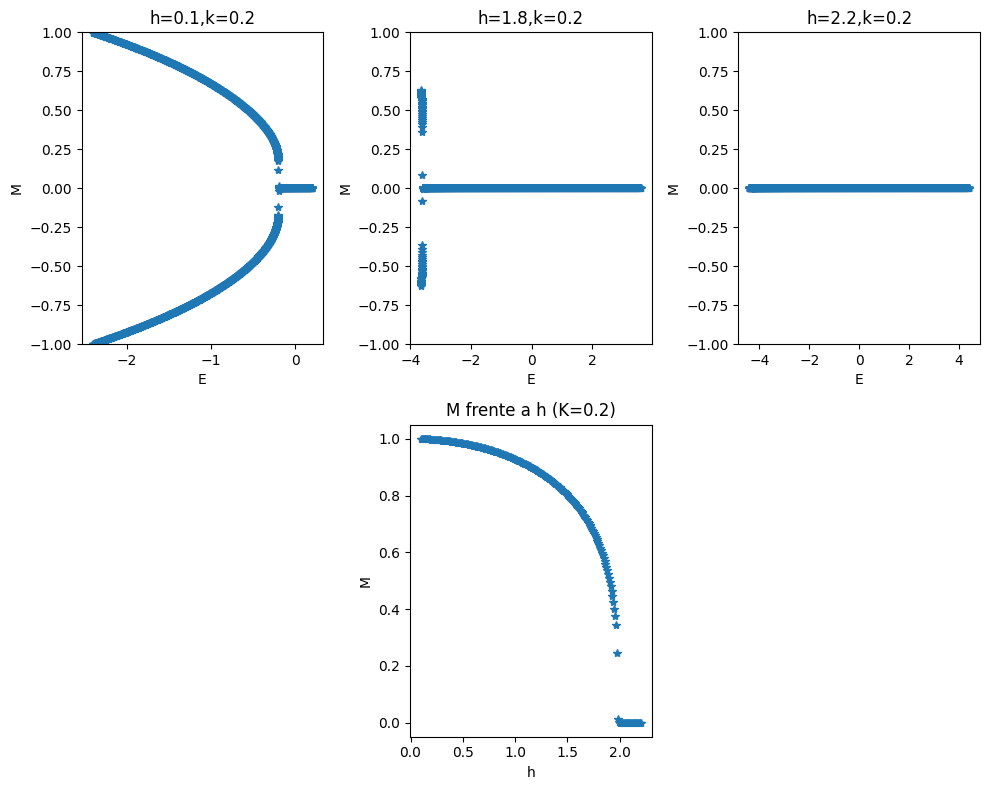

In [17]:
# Crear figura y grilla
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 3)  # 2 filas, 3 columnas

hp=np.linspace(0.1,2.2,250)
x1,y1=diagrama_de_fases(0.1,0.2,2000)
x2,y2=diagrama_de_fases(1.8,0.2,2000)
x3,y3=diagrama_de_fases(2.2,0.2,2000)


# Graficas superiores
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

# Gráfica inferior centrada (ocupa las 3 columnas)
ax4 = fig.add_subplot(gs[1, 1])  # Colocada en la posición central

# Dibujar las funciones
ax1.plot(x1, y1,'*')
ax1.set_title("h=0.1,k=0.2")
ax1.set_xlabel("E")
ax1.set_ylabel("M")
ax1.set_ylim(-1, 1)

ax2.plot(x2, y2 ,'*')
ax2.set_title("h=1.8,k=0.2")
ax2.set_xlabel("E")
ax2.set_ylabel("M")
ax2.set_ylim(-1, 1)


ax3.plot(x3, y3 ,'*')
ax3.set_title("h=2.2,k=0.2")
ax3.set_xlabel("E")
ax3.set_ylabel("M")
ax3.set_ylim(-1, 1)

ax4.plot(hp,Mf_vect(1500,hp,0.2),'*')
ax4.set_title("M frente a h (K=0.2)")
ax4.set_xlabel("h")
ax4.set_ylabel("M")


# Ajustar diseño
plt.tight_layout()
plt.show()


Como habíamos dicho el estado fundamental, es decir el de mínima energía, para valores de h menores a h=2J (con un K suficientemente pequeño) tenemos una magnetización no nula, de manera que entre los dos posibles valores, positivo y negativo, el sistema se decantará por alguno de ellos. Según nos acercamos al valor crítico esta ramificación se va haciendo más pequeña hasta desaparecer a partir de h=2J, algo que se hace más preciso según aumentamos N. Esto también se observa en el gráfico de M frente a h, que nos permite ver como efectivamente la magnetización en el estado fundamental disminuye hasta anularse en el punto crítico, y además lo hace de manera suave, sin cambios repentinos como dijimos analizando el sistema (transición de segundo orden). 

Para la QPT de primer orden:

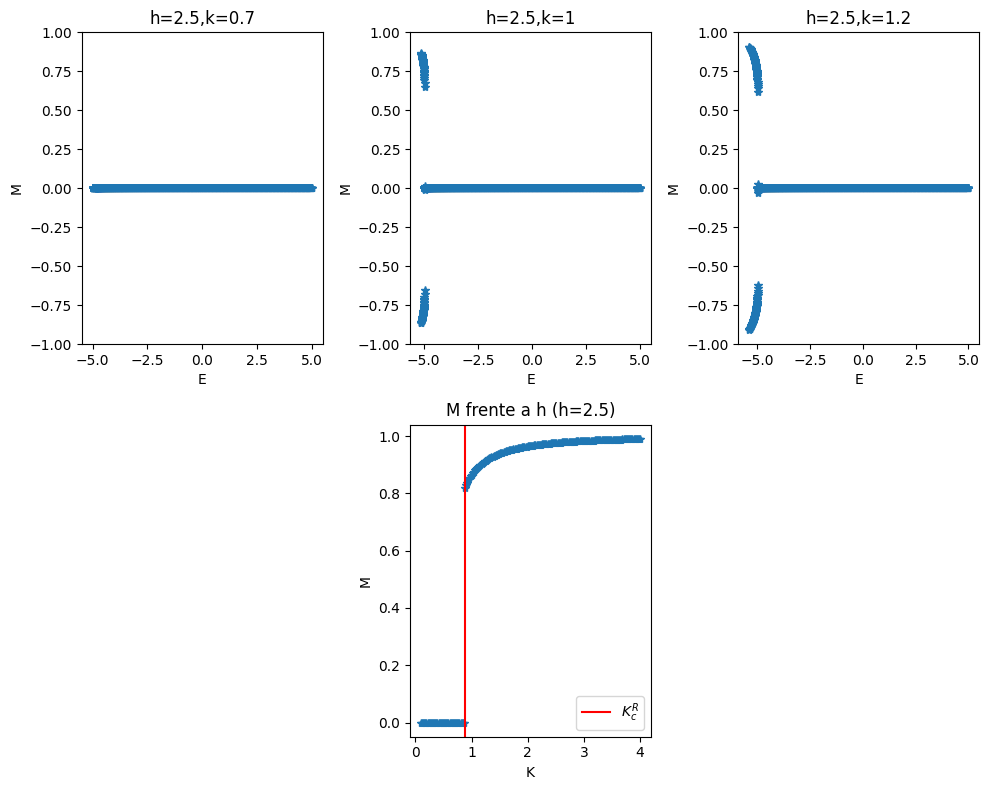

In [6]:
# Crear figura y grilla
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 3)  # 2 filas, 3 columnas

def K_c_R(h):
    return (27*h**2 - 36*h - 4 + np.sqrt( (9*h-2)**3 * (h-2))) / (64*h)

kp=np.linspace(0.1,4,200)
x1,y1=diagrama_de_fases(2.5,0.7,2000)
x2,y2=diagrama_de_fases(2.5,1,2000)
x3,y3=diagrama_de_fases(2.5,1.2,2000)


# Graficas superiores
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

# Gráfica inferior centrada (ocupa las 3 columnas)
ax4 = fig.add_subplot(gs[1, 1])  # Colocada en la posición central

# Dibujar las funciones
ax1.plot(x1, y1,'*')
ax1.set_title("h=2.5,k=0.7")
ax1.set_xlabel("E")
ax1.set_ylabel("M")
ax1.set_ylim(-1, 1)

ax2.plot(x2, y2 ,'*')
ax2.set_title("h=2.5,k=1")
ax2.set_xlabel("E")
ax2.set_ylabel("M")
ax2.set_ylim(-1, 1)


ax3.plot(x3, y3 ,'*')
ax3.set_title("h=2.5,k=1.2")
ax3.set_xlabel("E")
ax3.set_ylabel("M")
ax3.set_ylim(-1, 1)

ax4.plot(kp,Mf_vect(1000,2.5,kp),'*')
ax4.set_title("M frente a h (h=2.5)")
ax4.set_xlabel("K")
ax4.set_ylabel("M")
ax4.axvline(x=K_c_R(2.5),color='red',label=r"$K_{c}^{R}$")
ax4.legend()


# Ajustar diseño
plt.tight_layout()
plt.show()

In [4]:
kp=np.linspace(0.1,4,300)
hp=np.concatenate((np.linspace(0.1,1.8,150),np.linspace(1.8,2.2,200)))
hfix=Mf_vect(4000,hp,0)
ffix=Mf_vect(1000,2.5,kp)

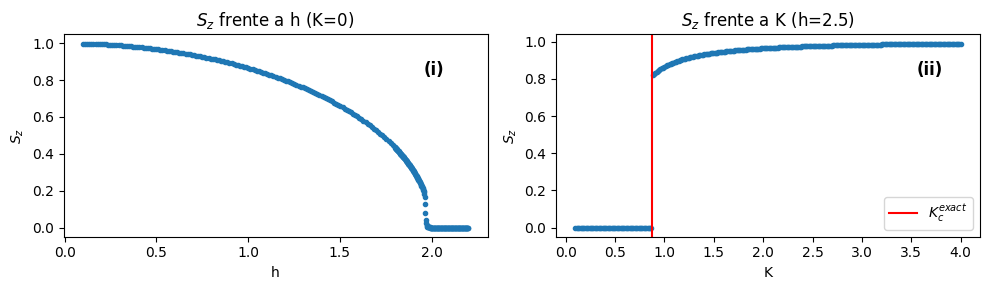

0.011409395973154365


In [7]:
fig = plt.figure(figsize=(10, 3))
gs = fig.add_gridspec(1, 2) 

kp=np.linspace(0.1,4,300)
hp=np.concatenate((np.linspace(0.1,1.8,150),np.linspace(1.8,2.2,200)))
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

def K_c_R(h):
    return (27*h**2 - 36*h - 4 + np.sqrt( (9*h-2)**3 * (h-2))) / (64*h)

ax1.plot(hp,hfix,'.')
ax1.set_title("$S_z$ frente a h (K=0)")
ax1.set_xlabel("h")
ax1.set_ylabel("$S_z$")
ax1.text(0.85, 0.8, "(i)", fontsize=12, fontweight='bold', transform=ax1.transAxes)

ax2.plot(kp,ffix,'.')
ax2.set_title("$S_z$ frente a K (h=2.5)")
ax2.set_xlabel("K")
ax2.set_ylabel("$S_z$")
ax2.axvline(x=K_c_R(2.5),color='red',label=r"$K_{c}^{exact}$")
ax2.text(0.85, 0.8, "(ii)", fontsize=12, fontweight='bold', transform=ax2.transAxes)
ax2.legend()

# Ajustar diseño
plt.tight_layout()
plt.show()
print(hp[1]-hp[0])

Como vemos, de nuevo se cumplen las predicciones del modelo teórico en nuestra simulación, al pasar de un estado paramagnético a otro ferromagnético a partir de un cierto $K_c$, pero esta vez con un cambio repentino de la magnetización al ser una transición de primer orden. Además, la $K$ crítica queda determinada con una precisión muy alta por la ecuación del modelo de Mathematica, lo que muestra la coherencia entre simulación y teoría.

# SISTEMA CLÁSICO

A continuación, comprobemos si a través de la mecánica clásica observamos también este tipo de transiciones en función de los parámetros del sistema. Para ello volvemos a nuestro hamiltoniano, pero para hacer un análisis del sistema e incluso poder ver su evolución temporal en un futuro, necesitamos que esté en función de las coordenadas generalizadas $q_{i}$ y momentos generalizados $p_{i}$. En este caso, según ha calculado alguien, hay que hacer la sustitución:

\begin{gather}
    S_{z} = \frac{q^{2}+p^{2}}{2} - 1\\
    S_{x} = q \frac{\sqrt{4-q^{2}-p^{2}}}{2}
\end{gather}

Para hacer más visual las curvas de nivel en el espacio de fases rotamos nuestro SDRF 90 grados de manera que $J_{z} \longrightarrow J_{x}$ y $J_{x} \longrightarrow -J_{z}$. Ahora construimos el hamiltoniano en nuestro código y estudiamos los mínimos de energía para diferentes valores de los parámetros h/J y K/J. Es importante hacer énfasis en que el hamiltoniano clásico no puede tener las dependencias en N, por ello se escogen los parámetros J --> (N/2) y K --> $(N/2)^3$ K. Para la transición de segundo orden en $h_c = 2J$.

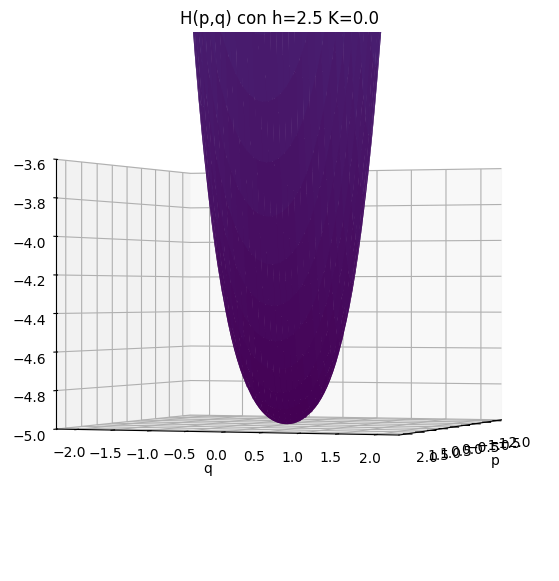

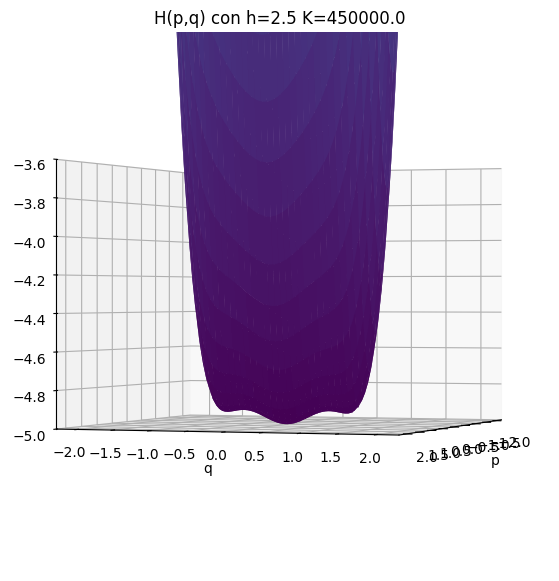

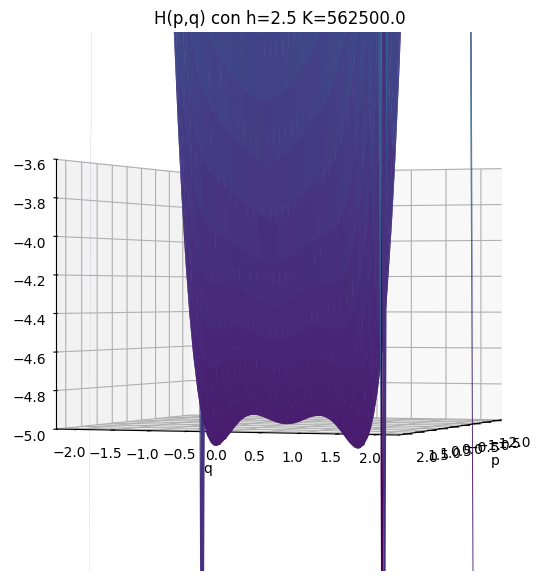

In [3]:
# Definir constantes
N = 1500
J = N/2



def plot_f_pq_3d(f, p_range=(-2, 2), q_range=(-2, 2), grid_size=100):
    p = np.linspace(p_range[0], p_range[1], grid_size)
    q = np.linspace(q_range[0], q_range[1], grid_size)
    P, Q = np.meshgrid(p, q)
    F = f(P, Q)
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(P, Q, F, cmap='viridis', edgecolor='none')
    ax.set_xlabel('p')
    ax.set_ylabel('q')
    #ax.set_zlabel('f(p, q)')
    ax.set_zlim(-5,-3.6)
    ax.view_init(elev=0, azim=20)


h = 2.5
K = 0*3*(N/2)**3
plot_f_pq_3d(lambda p, q: -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1))
plt.title(f"H(p,q) con h={h} K={K*2/N}")
plt.show()

h = 2.5
K = 0.8*(N/2)**3
plot_f_pq_3d(lambda p, q: -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1))
plt.title(f"H(p,q) con h={h} K={K*2/N}")
plt.show()

h = 2.5
K = 1*(N/2)**3
plot_f_pq_3d(lambda p, q: -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1))
plt.title(f"H(p,q) con h={h} K={K*2/N}")
plt.show()


Como observamos en el análisis clásico también aparecen este tipo de transiciones y en los mismos valores aproximadamente que en el caso cuántico en el límite termodinámico. Esto quiere decir que las QPTs y ESQPTs que son características de sistemas cuánticos, también se observan en sistemas clásicos de manera análoga. Para la transición de primer orden:

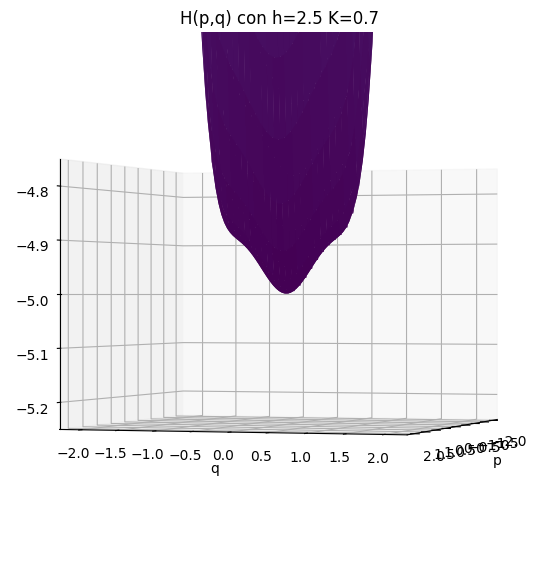

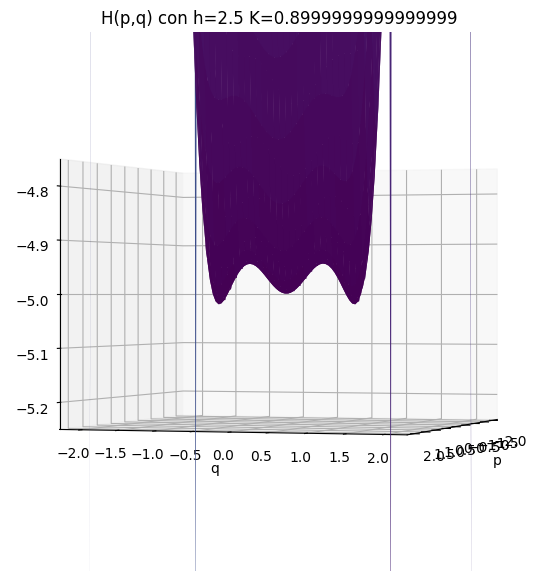

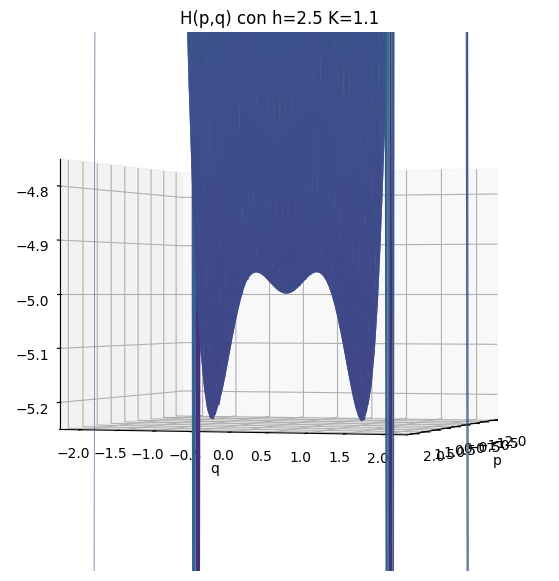

In [9]:
# Definir constantes
N = 1500
J = N/2
h = 2.5
K = 0*3*(N/2)**3

import matplotlib.pyplot as plt



def plot_f_pq_3d(f, p_range=(-2, 2), q_range=(-2, 2), grid_size=100):
    p = np.linspace(p_range[0], p_range[1], grid_size)
    q = np.linspace(q_range[0], q_range[1], grid_size)
    P, Q = np.meshgrid(p, q)
    F = f(P, Q)
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(P, Q, F, cmap='viridis', edgecolor='none')
    ax.set_xlabel('p')
    ax.set_ylabel('q')
    #ax.set_zlabel('f(p, q)')
    ax.set_zlim(-5.25,-4.75)
    ax.view_init(elev=0, azim=18)


K = 0.7*(N/2)**3
plot_f_pq_3d(lambda p, q: -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1))
plt.title(f"H(p,q) con h={h} K={K*(2/N)**3}")
plt.show()

K =0.9*(N/2)**3
plot_f_pq_3d(lambda p, q: -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1))
plt.title(f"H(p,q) con h={h} K={K*(2/N)**3}")
plt.show()

K = 1.1*(N/2)**3
plot_f_pq_3d(lambda p, q: -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1))
plt.title(f"H(p,q) con h={h} K={K*(2/N)**3}")
plt.show()

De nuevo aquí observamos la transición esperada.

Una vez analizados los hamiltonianos desde un punto de vista de la mecánica clásica y la mecánica estadística cuántica. Podemos plantearnos las evoluciones temporales de nuestro sistema desde ambos puntos tras aplicar un quench a nuestro sistema (cambio repentino de los parámetros del hamiltoniano) partiendo del estado fundamental. Comencemos de nuevo con el análisis cuántico del problema y utilizaremos dos quench de estados cercanos a la línea crítica de primer orden.

Partimos del estado fundamental del primer hamiltoniano, hacemos un cambio de base de ese estado a la base del hamiltoniano final y lo evolucionamos :

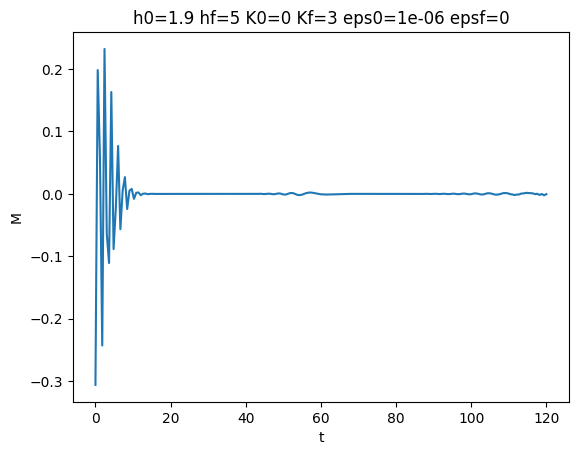

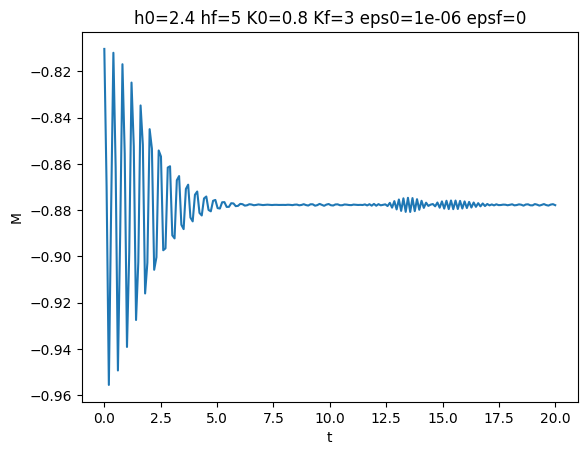

In [4]:
#1-----------------------------------------
#Partimos de un ferromagnetico y pasamos a un paramagnético en la frontera de la transición de fase de primer orden
evolution_time(1.9, 5,0,3,1e-6, 0, 0, 120, 200, 2000)
#2-------------------------------------------
#Partimos de un ferromagnetico y pasamos a un paramagnético en la frontera de la transición de fase de primer orden
evolution_time(2.4, 5,0.8,3,1e-6, 0, 0, 20, 200, 2000)

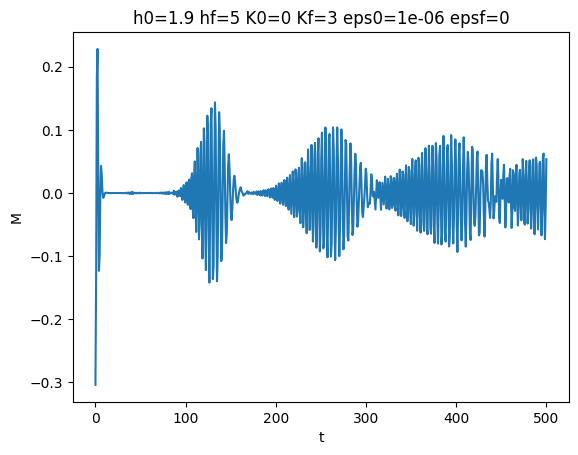

In [26]:
evolution_time(1.9, 5,0,3,1e-6, 0, 0, 500, 650, 1500)

También podemos dibujar la distribución de enegías de nuestro Hamiltoniano final dado el estado inicial del Hamiltoniano inicial.

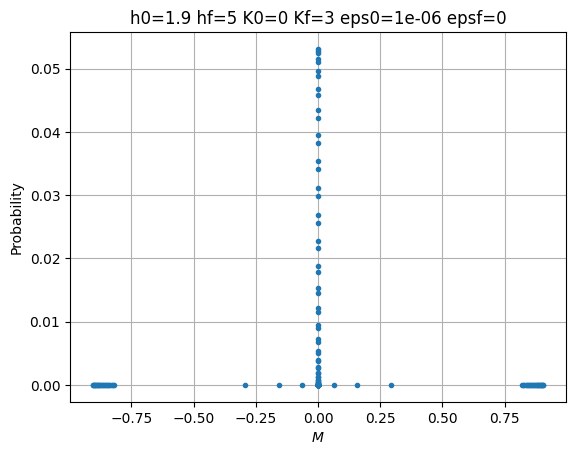

La máxima probabilidad se da para M = 2.3792336546415267e-14
La máxima probabilidad se da para E_n = -9.762044548498949


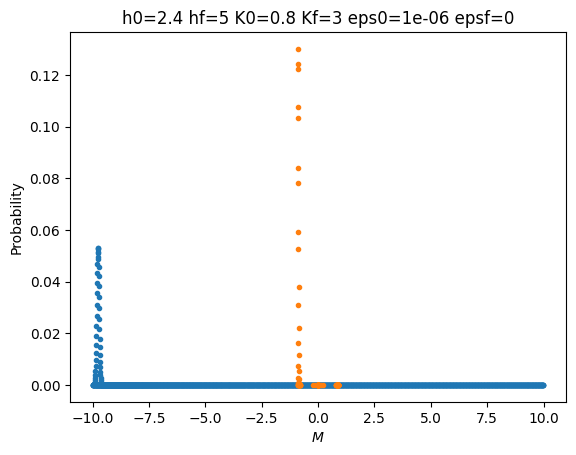

La máxima probabilidad se da para M = -0.8787100659724013
La máxima probabilidad se da para E_n = -9.766718508151293


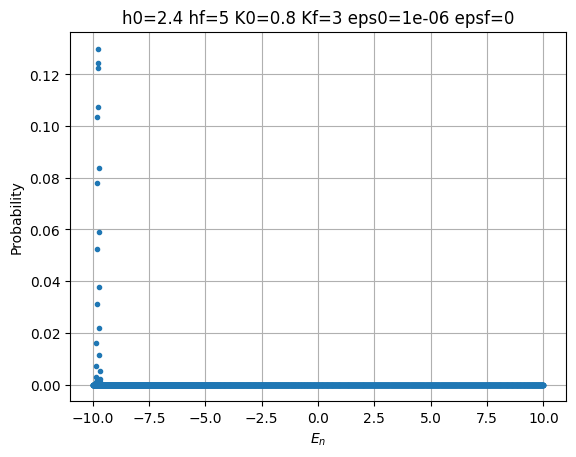

In [5]:
distribucion_energias(2000,1.9, 5,0,3,1e-6, 0)
distribucion_energias(3000,2.4, 5,0.8,3,1e-6, 0)

Desde el punto de vista clásico, calcularemos la evolución temporal desde las ecs de Hamilton:
\begin{gather}
\dot{q} = \frac{\partial H}{\partial p}\\
\dot{p} = -\frac{\partial H}{\partial q}
\end{gather}
Escogeremos de valores iniciales de p y q los correspondientes a puntos fijos ($\frac{\partial H}{\partial p} = 0,  -\frac{\partial H}{\partial q} = 0$) que dan lugar a mínimos en el hamiltoniano inicial, para posteriormente ser evolucionados con los nuevos valores de los parámetros h y K. Utilizando los mismos valores que en los dos casos anteriores tenemos:

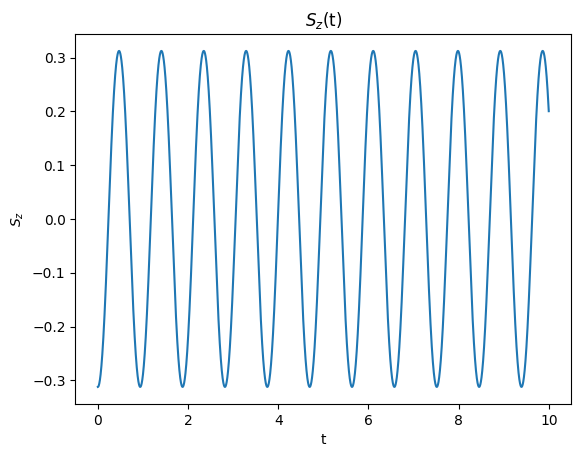

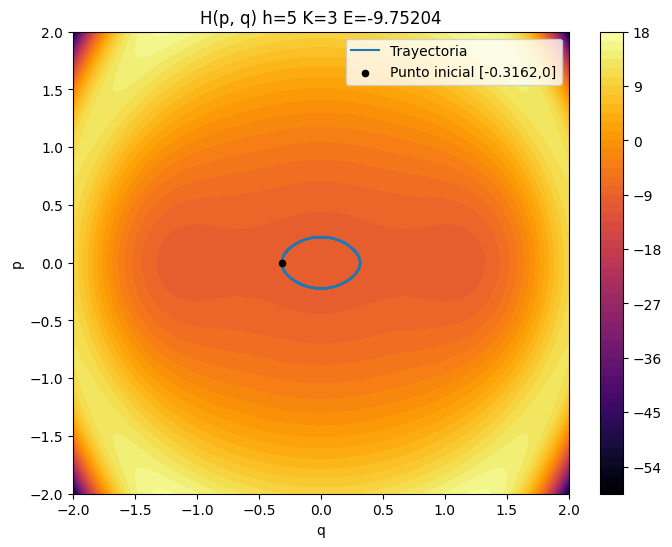

In [18]:
def H(p,q):
    N = 1500
    J = N/2
    h = 5
    K = 3*(N/2)**3
    return -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1)

def S_z(p,q):
    return q*np.sqrt(4-q**2-p**2)/2

def f(r,t):
    #Ahora usamos las variables finales para la evolucion temporal
    N = 1500
    J = N/2
    h = 5
    K = 3*(N/2)**3
    p=r[0]
    q=r[1]
    fp= -(2*q*(J*N**2*(p**2 + 2*q**2 - 4) + 2*K*q**2*(-p**2 - 2*q**2 + 4)*(p**2 + q**2 - 4) + N**3*h)/N**3)
    fq= 2*p*(J*N**2*q**2 - 2*K*q**4*(p**2 + q**2 - 4) + N**3*h)/N**3
    return np.array([fp,fq],float)


a=0 # punto inicial del intervalo
b=10 # punto final del intervalo
Np=10000 # número de puntos

hp=(b-a)/Np # tamaño del paso


tp=np.linspace(a,b,Np) # inicializamos nuestras soluciones para un array de puntos en t
pp=[]
qp=[]
r=np.array([0,-0.3162284851074219],float) # condiciones iniciales para nuestras soluciones

for t in tp:
    pp.append(r[0])
    qp.append(r[1])
    k1 = hp*f(r,t)
    k2 = hp*f(r+0.5*k1,t+0.5*hp)
    k3 = hp*f(r+0.5*k2,t+0.5*hp)
    k4 = hp*f(r+k3,t+hp)
    r += (k1+2*k2+2*k3+k4)/6
    

def H(p,q):
    N = 1500
    J = N/2
    h = 5
    K = 3*(N/2)**3
    return -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1)

H=np.vectorize(H)

mt.plot(tp,S_z(np.array(pp),np.array(qp)))
plt.title("$S_{z}$(t)")
plt.xlabel("t")
plt.ylabel("$S_{z}$")
plt.xlabel("t")
plt.show()

# Definir el rango de valores para P y Q
p_values = np.linspace(-2, 2, 500)  # Valores de P (eje y)
q_values = np.linspace(-2, 2, 500)  # Valores de Q (eje x)

# Crear la malla de valores de P y Q
P, Q = np.meshgrid(p_values, q_values)

# Evaluar H en cada punto de la malla
H_values = H(P, Q)

# Crear la figura
plt.figure(figsize=(8, 6))
plt.contourf(Q, P, H_values, levels=50, cmap='inferno')  # Heatmap de colores
plt.colorbar()  # Barra de colores
plt.xlabel("q")
plt.ylabel("p")
plt.title(f"H(p, q) h=5 K=3 E={H(r[0], r[1]):.5f}")
plt.plot(np.array(qp),np.array(pp),label="Trayectoria")
plt.scatter(-0.3162284851074219,0,s=20, zorder=5,color="black",label="Punto inicial [-0.3162,0]")
plt.legend()
plt.show()


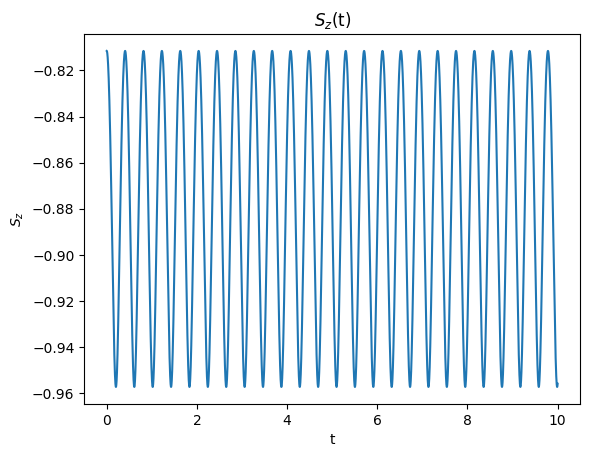

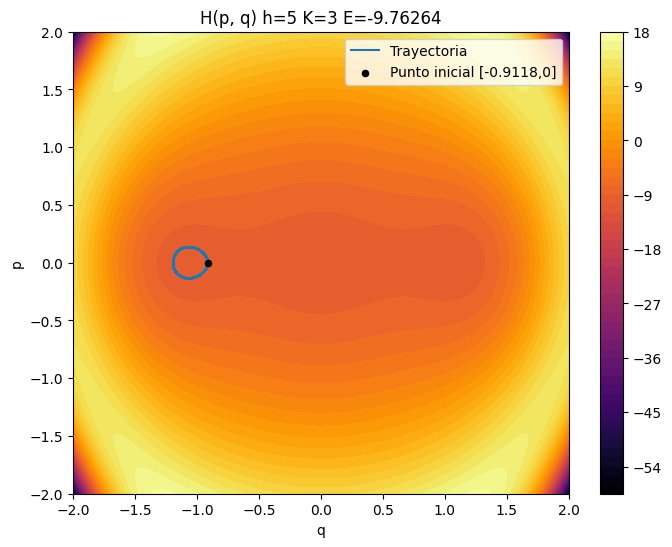

In [20]:
import numpy as np
import matplotlib.pyplot as plt
def H(p,q):
    N = 1500
    J = N/2
    h = 5
    K = 3*(N/2)**3
    return -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1)

def S_z(p,q):
    return q*np.sqrt(4-q**2-p**2)/2

def f(r,t):
    #Ahora usamos las variables finales para la evolucion temporal
    N = 1500
    J = N/2
    h = 5
    K = 3*(N/2)**3
    p=r[0]
    q=r[1]
    fp= -(2*q*(J*N**2*(p**2 + 2*q**2 - 4) + 2*K*q**2*(-p**2 - 2*q**2 + 4)*(p**2 + q**2 - 4) + N**3*h)/N**3)
    fq= 2*p*(J*N**2*q**2 - 2*K*q**4*(p**2 + q**2 - 4) + N**3*h)/N**3
    return np.array([fp,fq],float)


a=0 # punto inicial del intervalo
b=10 # punto final del intervalo
Np=15000 # número de puntos

hp=(b-a)/Np # tamaño del paso


tp=np.linspace(a,b,Np) # inicializamos nuestras soluciones para un array de puntos en t
pp=[]
qp=[]
r=np.array([0,-0.9118],float) # condiciones iniciales para nuestras soluciones



for t in tp:
    pp.append(r[0])
    qp.append(r[1])
    k1 = hp*f(r,t)
    k2 = hp*f(r+0.5*k1,t+0.5*hp)
    k3 = hp*f(r+0.5*k2,t+0.5*hp)
    k4 = hp*f(r+k3,t+hp)
    r += (k1+2*k2+2*k3+k4)/6
    
def H(p,q):
    N = 1500
    J = N/2
    h = 5
    K = 3*(N/2)**3
    return -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1)

H=np.vectorize(H)

mt.plot(tp,S_z(np.array(pp),np.array(qp)))
plt.title("$S_{z}$(t)")
plt.xlabel("t")
plt.ylabel("$S_{z}$")
plt.xlabel("t")
plt.show()

# Definir el rango de valores para P y Q
p_values = np.linspace(-2, 2, 500)  # Valores de P (eje y)
q_values = np.linspace(-2, 2, 500)  # Valores de Q (eje x)

# Crear la malla de valores de P y Q
P, Q = np.meshgrid(p_values, q_values)

# Evaluar H en cada punto de la malla
H_values = H(P, Q)

# Crear la figura 
plt.figure(figsize=(8, 6))
plt.contourf(Q, P, H_values, levels=50, cmap='inferno')  # Heatmap de colores
plt.colorbar()  # Barra de colores
plt.xlabel("q")
plt.ylabel("p")
plt.title(f"H(p, q) h=5 K=3 E={H(r[0], r[1]):.5f}")
plt.plot(np.array(qp),np.array(pp),label="Trayectoria")
plt.scatter(-0.9118,0,s=20, zorder=5,color="black",label="Punto inicial [-0.9118,0]")
plt.legend()
plt.show()


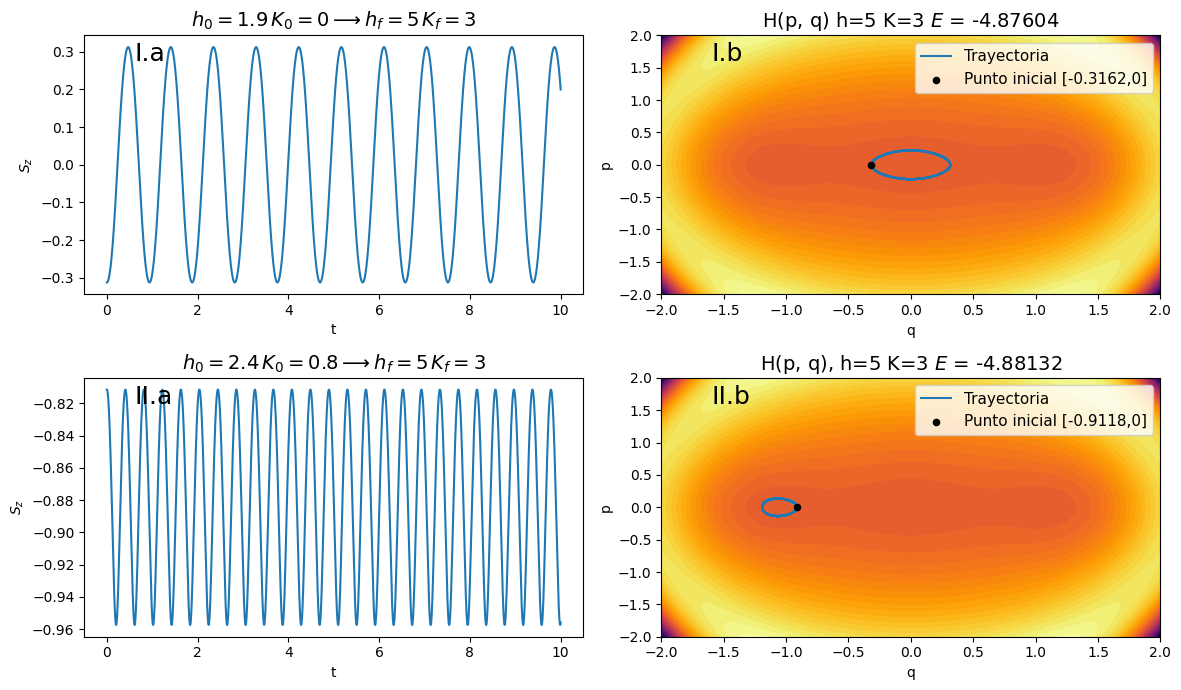

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Funciones generales
def H(p, q):
    N = 1500
    J = N/2
    h = 5
    K = 3*(N/2)**3
    return -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1)

def S_z(p, q):
    return q*np.sqrt(4 - q**2 - p**2)/2

def f(r, t):
    N = 1500
    J = N/2
    h = 5
    K = 3*(N/2)**3
    p, q = r
    fp = -(2*q*(J*N**2*(p**2 + 2*q**2 - 4) + 2*K*q**2*(-p**2 - 2*q**2 + 4)*(p**2 + q**2 - 4) + N**3*h)/N**3)
    fq = 2*p*(J*N**2*q**2 - 2*K*q**4*(p**2 + q**2 - 4) + N**3*h)/N**3
    return np.array([fp, fq], float)

def resolver_dinamica(r0, Np=10000, t0=0, tf=10):
    hp = (tf - t0) / Np
    tp = np.linspace(t0, tf, Np)
    r = np.array(r0, float)
    pp, qp = [], []

    for t in tp:
        pp.append(r[0])
        qp.append(r[1])
        k1 = hp * f(r, t)
        k2 = hp * f(r + 0.5 * k1, t + 0.5 * hp)
        k3 = hp * f(r + 0.5 * k2, t + 0.5 * hp)
        k4 = hp * f(r + k3, t + hp)
        r += (k1 + 2*k2 + 2*k3 + k4) / 6

    return tp, np.array(pp), np.array(qp), r

# Condiciones iniciales
inic1 = [0, -0.3162]
inic2 = [0, -0.9118]

# Evolución
tp1, pp1, qp1, r1f = resolver_dinamica(inic1)
tp2, pp2, qp2, r2f = resolver_dinamica(inic2, Np=15000)

# Crear rejilla
p_values = np.linspace(-2, 2, 500)
q_values = np.linspace(-2, 2, 500)
P, Q = np.meshgrid(p_values, q_values)
H_vec = np.vectorize(H)
H_values = H_vec(P, Q)

# Figura 2x2
fig, axs = plt.subplots(2, 2, figsize=(12, 7))

# Sz(t) primera condición
axs[0, 0].plot(tp1, S_z(pp1, qp1))
axs[0, 0].set_title(r"$h_0 =1.9 \, K_0 =0 \longrightarrow  h_f =5 \, K_f =3$", fontsize=14)
axs[0, 0].set_xlabel("t")
axs[0, 0].set_ylabel(r"$S_z$", fontsize=10)
axs[0, 0].text(0.1, 0.9, "I.a", transform=axs[0, 0].transAxes, fontsize=18)

# Plano fase primera condición
cs = axs[0, 1].contourf(Q, P, H_values, levels=50, cmap='inferno')
axs[0, 1].plot(qp1, pp1, label="Trayectoria")
axs[0, 1].scatter(inic1[1], inic1[0], color="black", s=20, zorder=5, label="Punto inicial [-0.3162,0]")
axs[0, 1].set_title(f"H(p, q) h=5 K=3 $E$ = {H(*inic1)/2:.5f}", fontsize=14)
axs[0, 1].set_xlabel("q")
axs[0, 1].set_ylabel("p", fontsize=10)
axs[0, 1].text(0.1, 0.9, "I.b", transform=axs[0, 1].transAxes, fontsize=18)
axs[0, 1].legend(fontsize=11)

# Sz(t) segunda condición
axs[1, 0].plot(tp2, S_z(pp2, qp2))
axs[1, 0].set_title(r"$h_0 =2.4 \, K_0 =0.8 \longrightarrow  h_f =5 \, K_f =3$", fontsize=14)
axs[1, 0].set_xlabel("t")
axs[1, 0].set_ylabel(r"$S_z$", fontsize=10)
axs[1, 0].text(0.1, 0.9, "II.a", transform=axs[1, 0].transAxes, fontsize=18)

# Plano fase segunda condición
cs2 = axs[1, 1].contourf(Q, P, H_values, levels=50, cmap='inferno')
axs[1, 1].plot(qp2, pp2, label="Trayectoria")
axs[1, 1].scatter(inic2[1], inic2[0], color="black", s=20, zorder=5, label="Punto inicial [-0.9118,0]")
axs[1, 1].set_title(f"H(p, q), h=5 K=3 $E$ = {H(*inic2)/2:.5f}", fontsize=14)
axs[1, 1].set_xlabel("q")
axs[1, 1].set_ylabel("p", fontsize=10)
axs[1, 1].text(0.1, 0.9, "II.b", transform=axs[1, 1].transAxes, fontsize=18)
axs[1, 1].legend(fontsize=11)



plt.tight_layout()
plt.show()


# COMPARACIÓN CLÁSICO Y CUÁNTICO

# Caso 1:

Como podemos ver en la evolución cuántica el sistema parte de un estado con magnetización inicial $M_0 \approx 0.31$ y oscila muy rápidamente en torno al 0, y al mismo tiempo desvaneciendose hasta anularse; para posteriormente tener un pequeño revival. Este revival es coherente con la evolución temporal de un sistema de este tipo pues ocurren en un tiempo en el que los argumentos de las composiciones de las exponenciales complejas provenientes de las evoluciones temporales dan lugar a un máximo o mínimo del valor esperado de la magnetización.

En cuanto a la evolución clásica, observamos oscilaciones perpétuas en torno a M=0 (promedio temporal nulo), comenzando en un valor de q que utilizando la expresion de la relación de p y q con S_z vemos que coincide con el inicia del cuántico. Como vemos en el espacio de fases una vez fijada la energía inicial el sistema se queda encerrado en una trayectoria con magnetización nula en promedio temporal también.

La conclusión que podemos sacar aquí, es que el sistema cuántico y clásico comienzan evolucionando de la misma manera, sin embargo los efectos cuánticos rápidamente se hacen notables y el sistema evoluciona según la física cuántica, que tiene una superposición de autoestados con diferentes energías en lugar de tener una fijada. Veamos que ocurre en la evolución temporal cuántica según N aumenta en el sistema cuántico, es decir, según nos acercamos al límite termodinámico, un tamaño mayor y por lo tanto al límite clásico-cuántico.

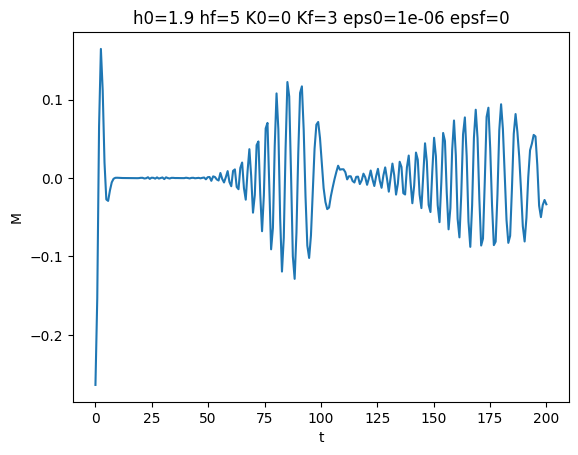

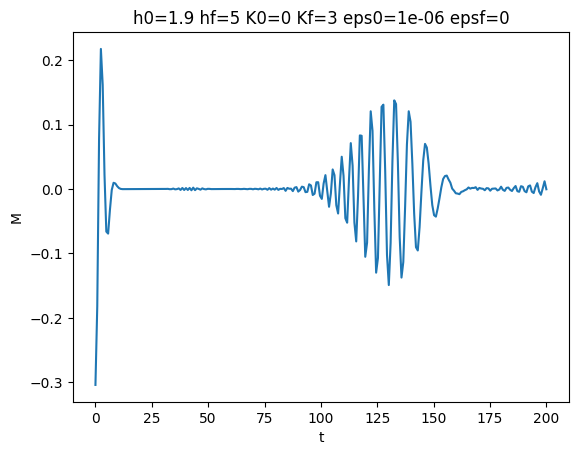

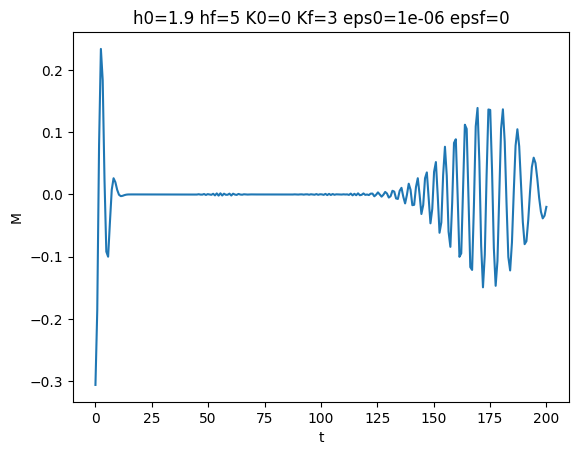

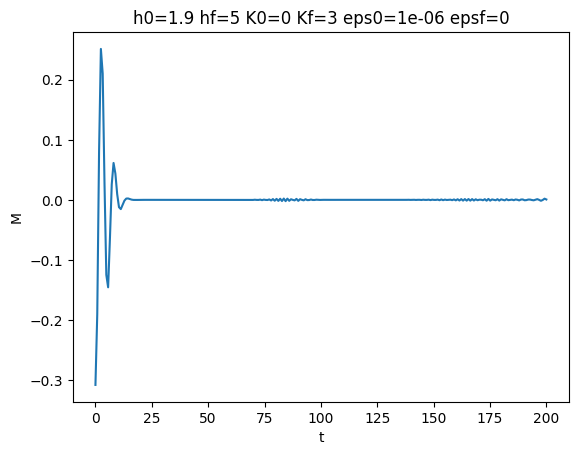

In [25]:
evolution_time(1.9, 5,0,3,1e-6, 0, 0, 200, 250, 1500)
evolution_time(1.9, 5,0,3,1e-6, 0, 0, 200, 250, 2000)
evolution_time(1.9, 5,0,3,1e-6, 0, 0, 200, 250, 3000)

Como podemos ver efectivamente según aumenta N el $\Delta$t inicial en el que la evolución temporal se asejema a la del sistema clásico es mayor, y también aumenta el tiempo en el que aparecen esos revivals, propios del comportamiento cuántico.

Probemos a observar la semejanza del cuántico al clásico en tiempos cortos para poder trabajar con N más grandes:

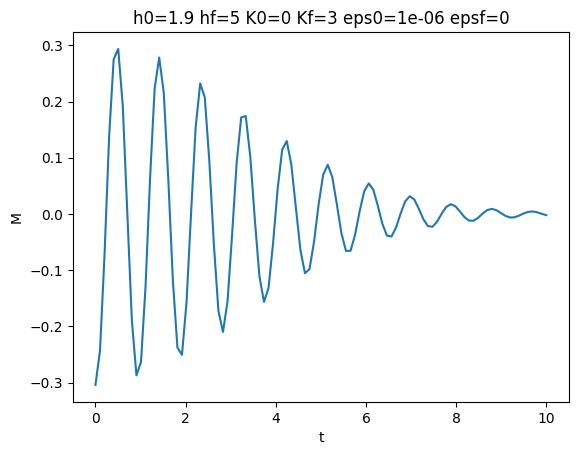

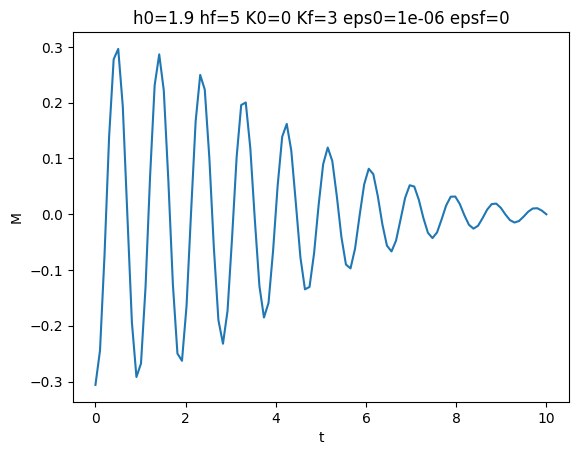

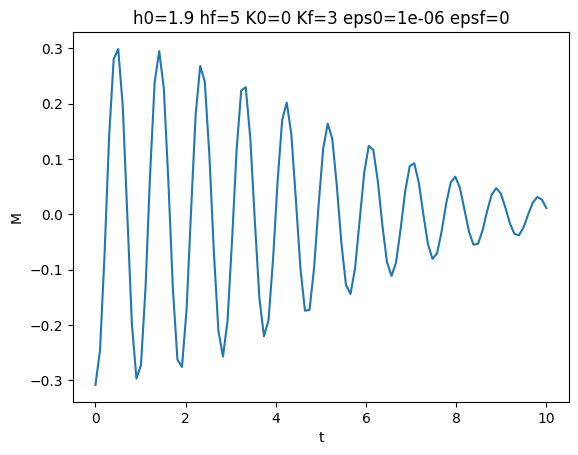

In [41]:
evolution_time(1.9, 5,0,3,1e-6, 0, 0, 10, 100, 1500)
evolution_time(1.9, 5,0,3,1e-6, 0, 0, 10, 100, 2000)
evolution_time(1.9, 5,0,3,1e-6, 0, 0, 10, 100, 3000)

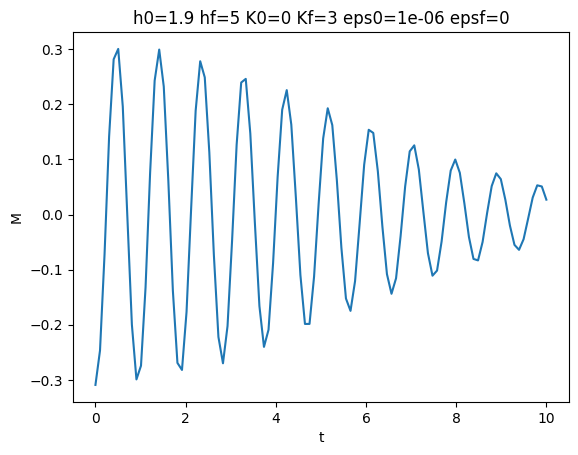

In [43]:
evolution_time(1.9, 5,0,3,1e-6, 0, 0, 10, 100, 4000)

 Algo más que podemos comprobar es la distribución de energía que se da en el análisis cuántico. Para el caso 1, según el análisis clásico la energía dadas esas condiciones iniciales, y que se mantiene constante durante todo el movimiento, es de $E_{1}$=-9.75203659564441

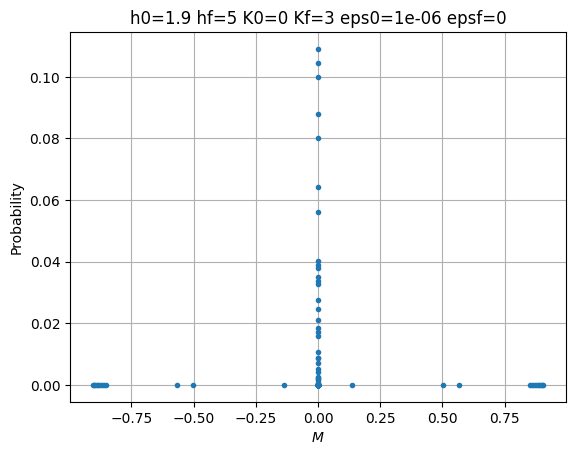

La máxima probabilidad se da para M = 2.4354316752667176e-14
La máxima probabilidad se da para E_n = -9.770489239739145


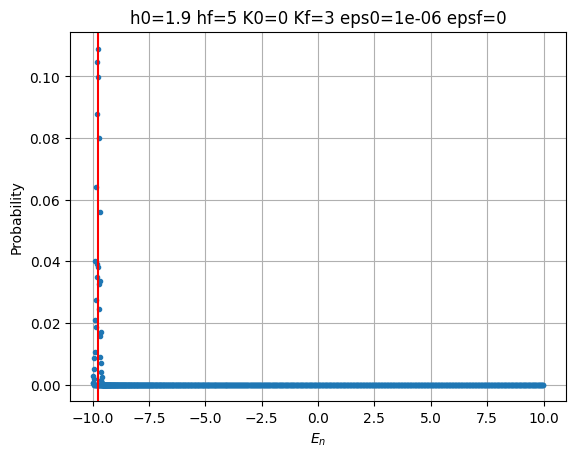

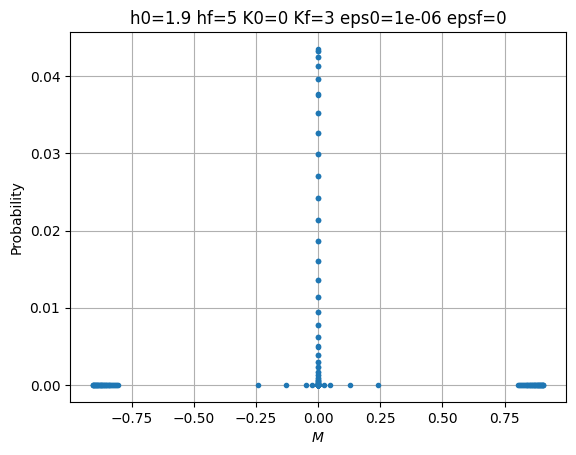

La máxima probabilidad se da para M = 1.2156875553295996e-14
La máxima probabilidad se da para E_n = -9.759233049936542


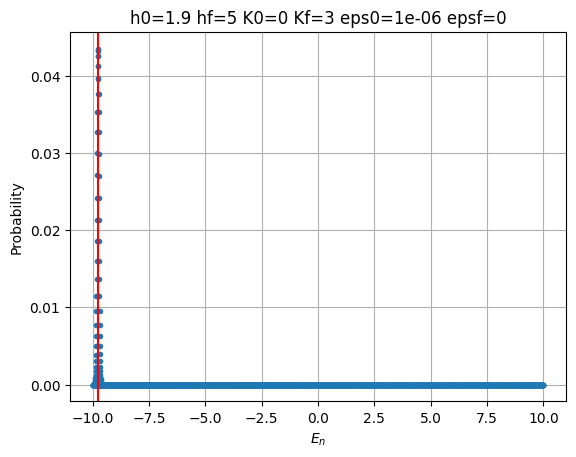

In [26]:
print("Para N=1000:")
distribucion_energias(1000,1.9, 5,0,3,1e-6, 0)
plt.axvline(x=-9.75203659564441, color='red')
plt.show()
print("Para N=3000:")
distribucion_energias(3000,1.9, 5,0,3,1e-6, 0)
plt.axvline(x=-9.75203659564441, color='red')
plt.show()

Como podemos observar, efectivamente el pico de energía de la distribución se sitúa en la misma posición que la energía del sistema clásico, acercándose cada vez más y teniendo una menor desviación típica según aumenta N.

# Caso 2: 
Aquí de nuevo, vemos que el valor de la magnetización oscila entre los mismos valores que en el caso clásico, también observándose una mayor proximidad a la evolución clásica segun aumenta N. Además, aparecen los revivals igual que en el caso anterior.




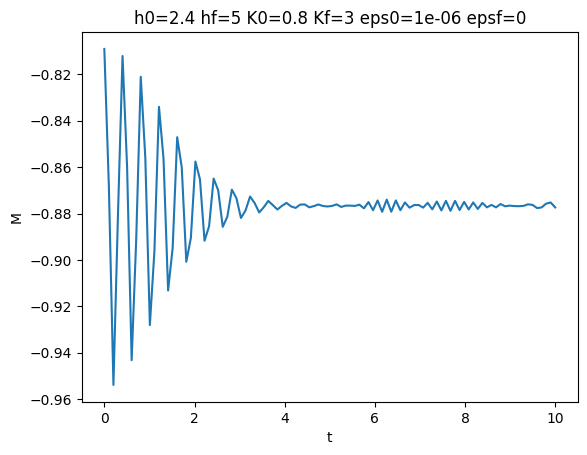

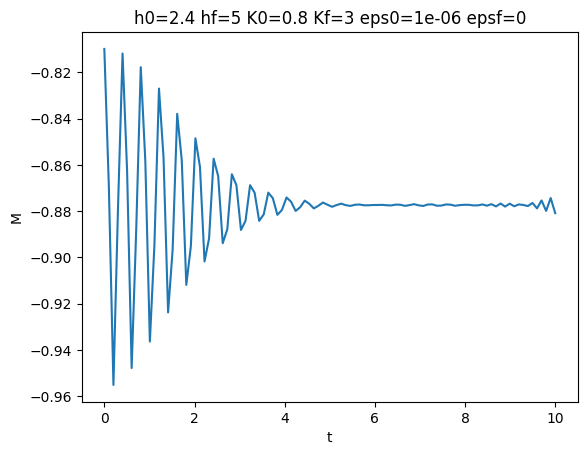

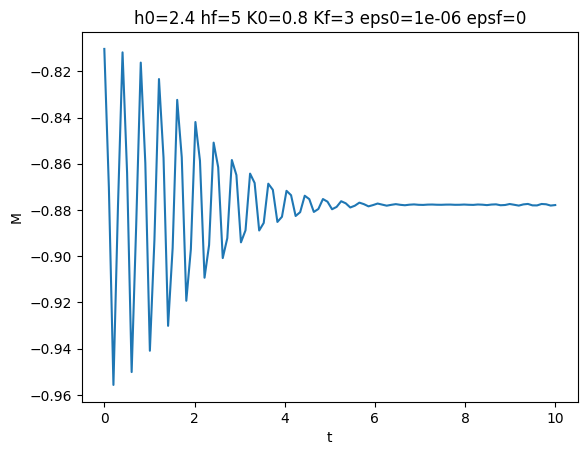

In [34]:
evolution_time(2.4, 5,0.8,3,1e-6, 0, 0, 20, 100, 1000)
evolution_time(2.4, 5,0.8,3,1e-6, 0, 0, 10, 100, 1500)
evolution_time(2.4, 5,0.8,3,1e-6, 0, 0, 10, 100, 2000)

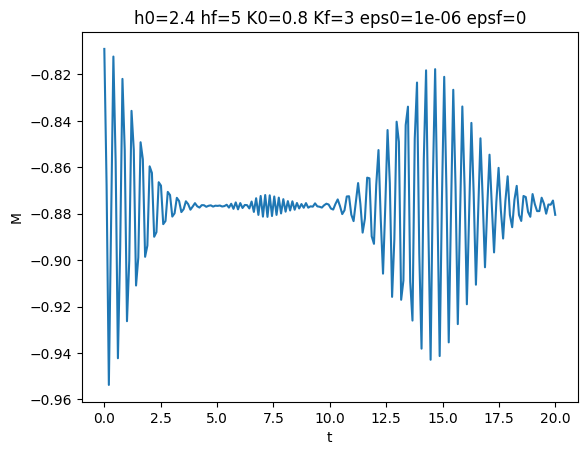

In [35]:
evolution_time(2.4, 5,0.8,3,1e-6, 0, 0, 20, 200, 1000)

Con las distribuciones de energía también ocurre lo mismo, acercándose y afinándose el pico cada vez más al valor de la energía de la trayectoria final del sistema $E_{2}=-9.762643162755834$:

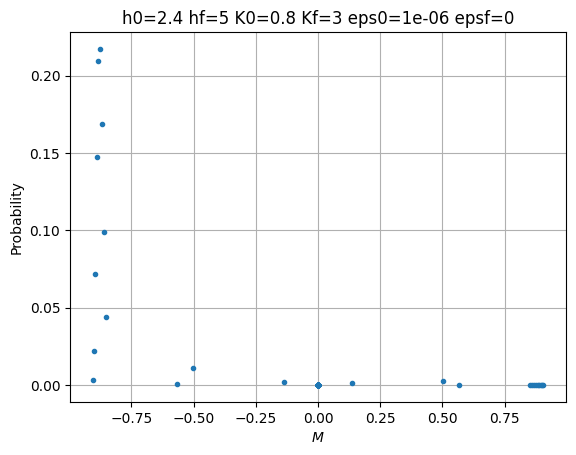

La máxima probabilidad se da para M = -0.8755769199787201
La máxima probabilidad se da para E_n = -9.761204946099696


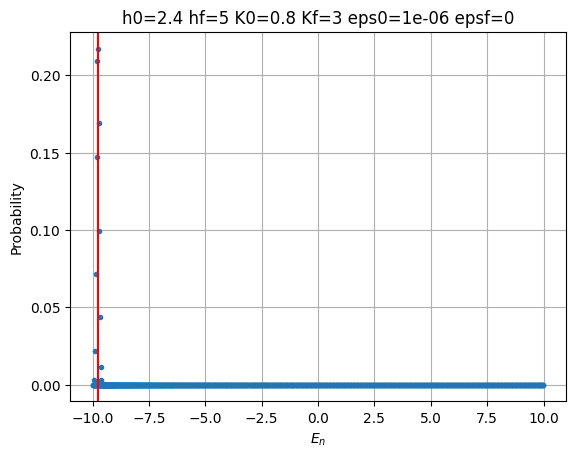

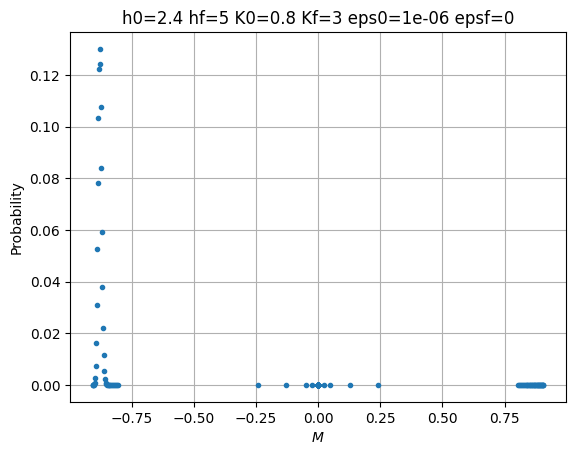

La máxima probabilidad se da para M = -0.8787100659724013
La máxima probabilidad se da para E_n = -9.766718508151293


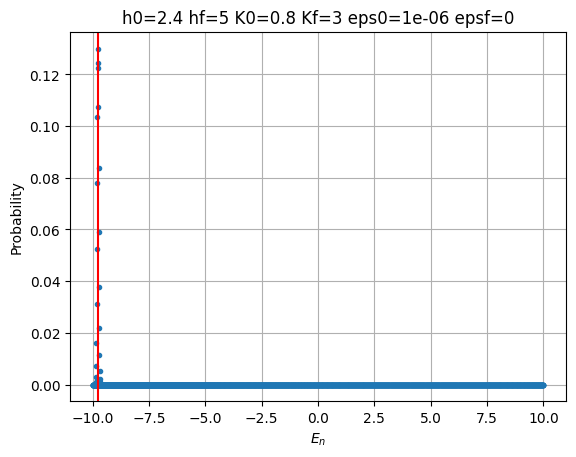

In [41]:
distribucion_energias(1000,2.4, 5,0.8,3,1e-6, 0)
plt.axvline(x=-9.762643162755834, color='red')
plt.show()

distribucion_energias(3000,2.4, 5,0.8,3,1e-6, 0)
plt.axvline(x=-9.762643162755834, color='red')
plt.show()

Algo que también observamos es que para valores bajos de N la distribución de energías es más dispersa, pero no de una manera simétrica sino asimétrica. Es decir, presenta una cola mas larga y ancha que la otra.

# TRAYECTORIAS EN ESPACIO DE FASES EN FUNCIÓN DE CONDICIONES INICIALES-CLÁSICO

A continuación, fijo el hamiltoniano final que hemos utilizado hasta ahora con h=5 y K=3, y estudio las diferentes curvas de nivel del hamiltoniano para observar las diferentes trayectorias en el espacio de fases que puede tomar el sistema, y por ende, analizar su magnetización media en el tiempo. Podríamos utilizar otro hamiltoniano distinto, pero escogemos este con un estado fundamental paramagnético que también nos permite mostrar toda la fenomelogía que se busca.

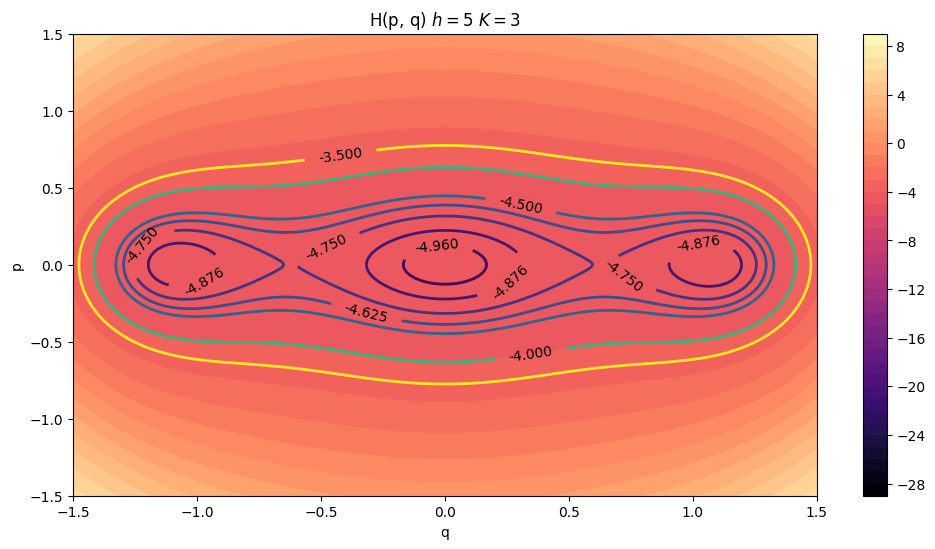

In [70]:
def H(p,q):
    N = 1500
    J = N/2
    h = 5
    K = 3*(N/2)**3
    return -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1)

H=np.vectorize(H)

# Definir el rango de valores para P y Q
p_values = np.linspace(-2, 2, 700)  # Valores de P (eje y)
q_values = np.linspace(-2, 2, 700)  # Valores de Q (eje x)

# Crear la malla de valores de P y Q
P, Q = np.meshgrid(p_values, q_values)

# Evaluar H en cada punto de la malla
H_values = H(P, Q)

# Crear la figura 
plt.figure(figsize=(12, 6))

# Dibujar el heatmap de colores
plt.contourf(Q, P, H_values/2, levels=40, cmap='magma')
plt.colorbar()  # Barra de colores

# Crear y etiquetar las curvas de nivel
contour = plt.contour(Q, P, H_values/2, levels=[-9.92/2,-9.752/2,-9.50/2,-9.25/2,-9/2,-8/2,-7/2], linewidths=2, linestyles='solid')
plt.clabel(contour, inline=True, fontsize=10, fmt="%2.3f", colors='black')

# Etiquetas de los ejes y título
plt.xlabel("q")
plt.ylabel("p")
plt.ylim([-1.5,1.5])
plt.xlim([-1.5,1.5])
plt.title(r"H(p, q) $h=5$ $K=3$")

# Mostrar la gráfica
plt.show()

Utilizando las curvas de nivel de este hamiltoniano, en primer lugar podemos ver como en función de las condiciones iniciales $p_{0}$ y $q_{0}$, que fijan la energía de la trayectoria, podemos tener diferentes comportamientos de la magnetización del sistema. Para valores menores a aproximadamente E=-9.92 la partícula únicamente podría encerrarse en una trayectoria en torno al (0,0) que le dotaría de una magnetización promedio nula. Sin embargo, a partir de esa energía, aparecen 3 trayectorias, 2 de ellas con magnetización promedio distinta de cero (ferromagnético) y una nula. Esto tiene que ver con la convivencia de estados paramagnéticos y ferromagnéticos que veíamos anteriormente cerca de la transición de primer orden. Entonces, para diferentes valores de p y q podemos tener la misma energía, pero ahora con diferentes valores de la magnetización media en función de estos. Las condiciones iniciales encerrarían al sistema en uno de estos pozos.

Para continuar, según aumentamos la energía observamos que para aproximadamente E=-9.5 se produce un cruce de una misma trayectoria, y a partir de este las siguientes trayectorias oscilan en torno al cero (magnetización nula promedio). Como ya sabemos, las trayectorias en el espacio de fases no se pueden cruzar por la unicidad de la evolución temporal en sistemas dinámicos deterministas, que es consecuencia del Teorema de Existencia y Unicidad de las EDOs. La consecuencia de esto es que en función de las condiciones iniciales, el sistema comenzará en uno de los 3 pozos y evolucionará hacia uno de los puntos fijos llegando a este en un tiempo infinito. A su vez, esta intersección nos indica otro cambio de fase del sistema en función de la energía, que a partir de un valor crítico se comporta únicamente como paramagnético.

Este diagrama y las energías críticas de cambios de fase son totalmente coherentes con la forma de la energía:

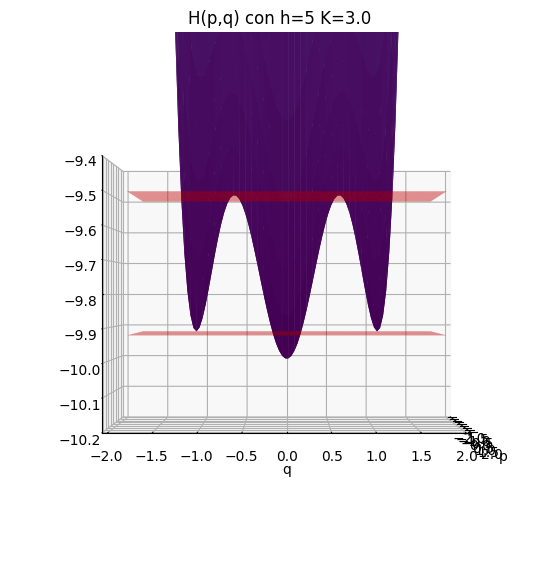

In [78]:
# Definir constantes
N = 1500
J = N/2
h = 5
K = 3*(N/2)**3
def plot_f_pq_3d(f, p_range=(-1.8, 1.8), q_range=(-1.8, 1.8), grid_size=100):
    p = np.linspace(p_range[0], p_range[1], grid_size)
    q = np.linspace(q_range[0], q_range[1], grid_size)
    P, Q = np.meshgrid(p, q)
    F = f(P, Q)
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(P, Q, F, cmap='viridis', edgecolor='none')
    ax.set_xlabel('p')
    ax.set_ylabel('q')
    #ax.set_zlabel('f(p, q)')
    ax.set_zlim(-10.2,-9.4)
    ax.view_init(elev=0, azim=0)
    # Añadir planos
    Z_plane = np.full_like(P, -9.92)  # Crear una matriz del mismo tamaño que P con valores de -10
    ax.plot_surface(P, Q, Z_plane, color='red', alpha=0.5)  # Dibujar el plano en rojo con transparencia
    # Añadir planos
    Z_plane = np.full_like(P, -9.5)  # Crear una matriz del mismo tamaño que P con valores de -10
    ax.plot_surface(P, Q, Z_plane, color='red', alpha=0.5)  # Dibujar el plano en rojo con transparencia
    # Añadir planos

plot_f_pq_3d(lambda p, q: -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1))
plt.title(f"H(p,q) con h={h} K={K*(2/N)**3}")
plt.show()

Como podemos ver, a partir de una energía $E_{c1} \approx -9.92$ conviven estados paramagnéticos y ferromagnéticos, después de $E_{c2} \approx -9.5$ el sistema explora diferentes valores de q, pero teniendo en promedio $<M>$=0.

Ya hemos comprobado lo que ocurre cuando la energía es aproximadamente $E \approx -9.75$ con dos condiciones iniciales distintas, una con una evolución temporal con magnetización promedio nula y la otra con magnetización promedio no nula. Ahora busquemos obtener a partir del estado fundamental de un hamiltoniano inicial evoluciones temporales con energías por debajo de $E_{c1}$ y otro que nos las proporcione por encima de $E_{c2}$. Para ello probamos con hamiltonianos iniciales que nos den mínimos (p,q) que al probar en el hamiltoniano final nos den energías en el rango que nos interesa.

Para un $H_0$ con h=1.98 y K=0 accedemos al único estado posible, paramagnético, para una energía $E<E_{c1}$:

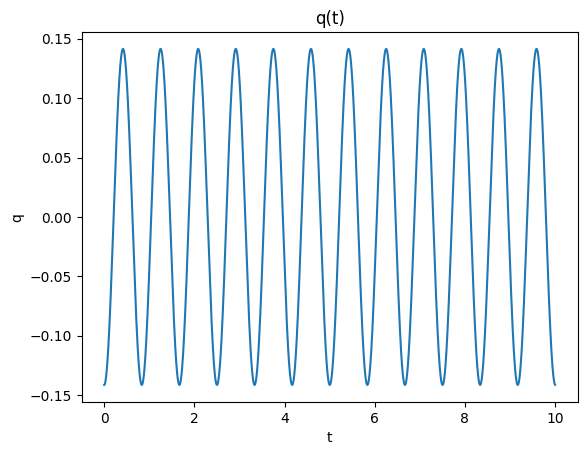

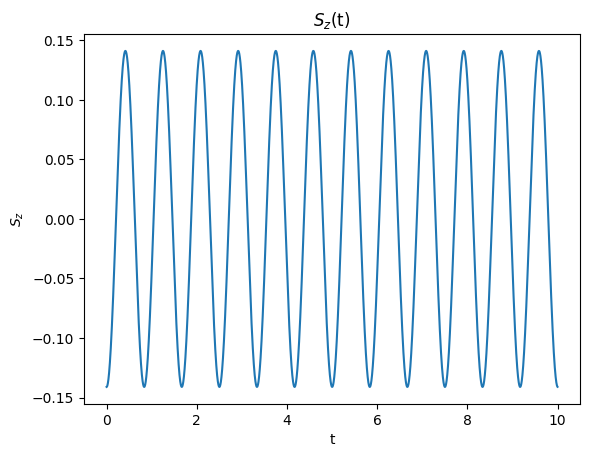

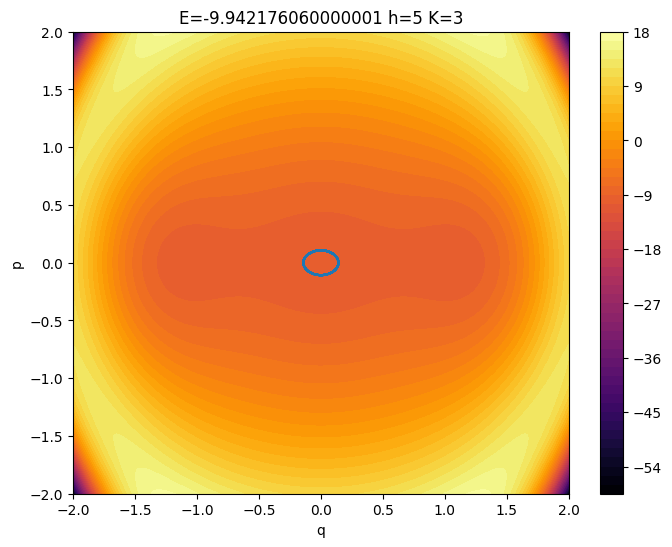

In [15]:
import numpy as np
import matplotlib.pyplot as plt
def H(p,q):
    N = 1500
    J = N/2
    h = 5
    K = 3*(N/2)**3
    return -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1)

def S_z(p,q):
    return q*np.sqrt(4-q**2-p**2)/2

def f(r,t):
    #Ahora usamos las variables finales para la evolucion temporal
    N = 1500
    J = N/2
    h = 5
    K = 3*(N/2)**3
    p=r[0]
    q=r[1]
    fp= -(2*q*(J*N**2*(p**2 + 2*q**2 - 4) + 2*K*q**2*(-p**2 - 2*q**2 + 4)*(p**2 + q**2 - 4) + N**3*h)/N**3)
    fq= 2*p*(J*N**2*q**2 - 2*K*q**4*(p**2 + q**2 - 4) + N**3*h)/N**3
    return np.array([fp,fq],float)


a=0 # punto inicial del intervalo
b=10 # punto final del intervalo
Np=15000 # número de puntos

hp=(b-a)/Np # tamaño del paso


tp=np.linspace(a,b,Np) # inicializamos nuestras soluciones para un array de puntos en t
pp=[]
qp=[]
r=np.array([0,-0.14142135623730995],float) # condiciones iniciales para nuestras soluciones



for t in tp:
    pp.append(r[0])
    qp.append(r[1])
    k1 = hp*f(r,t)
    k2 = hp*f(r+0.5*k1,t+0.5*hp)
    k3 = hp*f(r+0.5*k2,t+0.5*hp)
    k4 = hp*f(r+k3,t+hp)
    r += (k1+2*k2+2*k3+k4)/6
    

plt.plot(tp,qp)
plt.title("q(t)")
plt.xlabel("t")
plt.ylabel("q")
plt.xlabel("t")
plt.show()

def H(p,q):
    N = 1500
    J = N/2
    h = 5
    K = 3*(N/2)**3
    return -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1)

H=np.vectorize(H)

mt.plot(tp,S_z(np.array(pp),np.array(qp)))
plt.title("$S_{z}$(t)")
plt.xlabel("t")
plt.ylabel("$S_{z}$")
plt.xlabel("t")
plt.show()

# Definir el rango de valores para P y Q
p_values = np.linspace(-2, 2, 500)  # Valores de P (eje y)
q_values = np.linspace(-2, 2, 500)  # Valores de Q (eje x)

# Crear la malla de valores de P y Q
P, Q = np.meshgrid(p_values, q_values)

# Evaluar H en cada punto de la malla
H_values = H(P, Q)

# Crear la figura 
plt.figure(figsize=(8, 6))
plt.contourf(Q, P, H_values, levels=50, cmap='inferno')  # Heatmap de colores
plt.colorbar()  # Barra de colores
plt.xlabel("q")
plt.ylabel("p")
plt.title(f"E={H(0,-0.14142135623730995)} h=5 K=3")
plt.plot(np.array(qp),np.array(pp))
plt.show()

Para un $H_0$ con h=0.05 y K=0 accedemos de nuevo al único estado posible, paramagnético, para una energía $E>E_{c2}$:

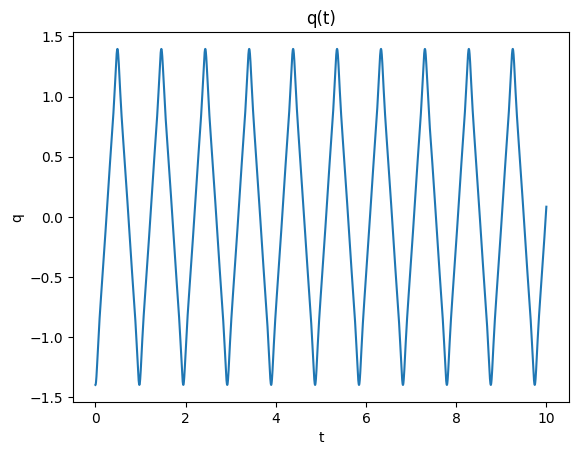

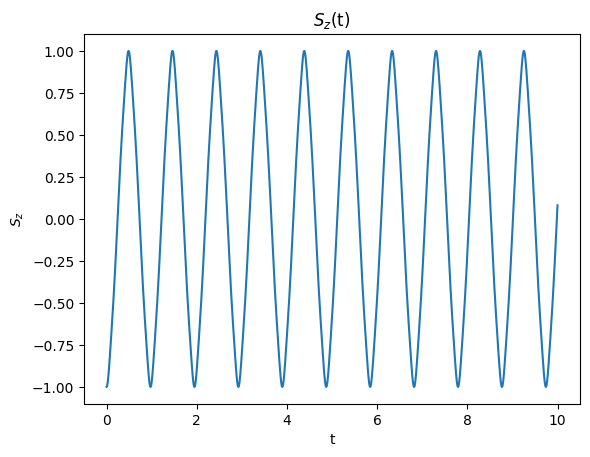

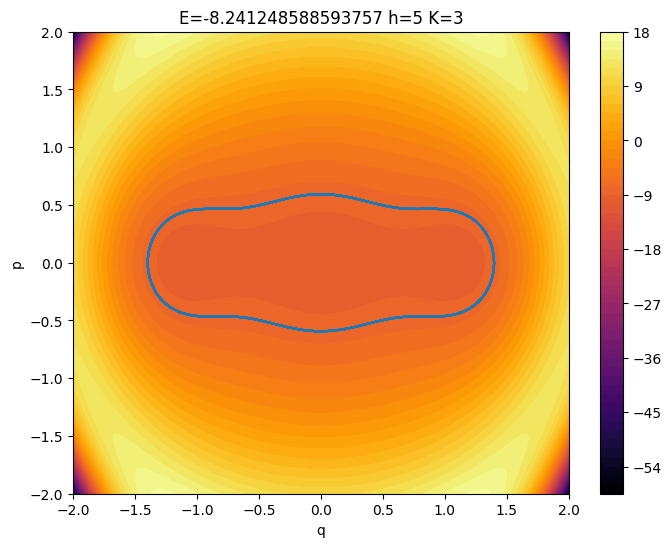

In [9]:
import numpy as np
import matplotlib.pyplot as plt
def H(p,q):
    N = 1500
    J = N/2
    h = 5
    K = 3*(N/2)**3
    return -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1)

def S_z(p,q):
    return q*np.sqrt(4-q**2-p**2)/2

def f(r,t):
    #Ahora usamos las variables finales para la evolucion temporal
    N = 1500
    J = N/2
    h = 5
    K = 3*(N/2)**3
    p=r[0]
    q=r[1]
    fp= -(2*q*(J*N**2*(p**2 + 2*q**2 - 4) + 2*K*q**2*(-p**2 - 2*q**2 + 4)*(p**2 + q**2 - 4) + N**3*h)/N**3)
    fq= 2*p*(J*N**2*q**2 - 2*K*q**4*(p**2 + q**2 - 4) + N**3*h)/N**3
    return np.array([fp,fq],float)


a=0 # punto inicial del intervalo
b=10 # punto final del intervalo
Np=15000 # número de puntos

hp=(b-a)/Np # tamaño del paso


tp=np.linspace(a,b,Np) # inicializamos nuestras soluciones para un array de puntos en t
pp=[]
qp=[]
r=np.array([0,-1.3964242935180664],float) # condiciones iniciales para nuestras soluciones



for t in tp:
    pp.append(r[0])
    qp.append(r[1])
    k1 = hp*f(r,t)
    k2 = hp*f(r+0.5*k1,t+0.5*hp)
    k3 = hp*f(r+0.5*k2,t+0.5*hp)
    k4 = hp*f(r+k3,t+hp)
    r += (k1+2*k2+2*k3+k4)/6
    

plt.plot(tp,qp)
plt.title("q(t)")
plt.xlabel("t")
plt.ylabel("q")
plt.xlabel("t")
plt.show()

def H(p,q):
    N = 1500
    J = N/2
    h = 5
    K = 3*(N/2)**3
    return -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1)

H=np.vectorize(H)

mt.plot(tp,S_z(np.array(pp),np.array(qp)))
plt.title("$S_{z}$(t)")
plt.xlabel("t")
plt.ylabel("$S_{z}$")
plt.xlabel("t")
plt.show()

# Definir el rango de valores para P y Q
p_values = np.linspace(-2, 2, 500)  # Valores de P (eje y)
q_values = np.linspace(-2, 2, 500)  # Valores de Q (eje x)

# Crear la malla de valores de P y Q
P, Q = np.meshgrid(p_values, q_values)

# Evaluar H en cada punto de la malla
H_values = H(P, Q)

# Crear la figura 
plt.figure(figsize=(8, 6))
plt.contourf(Q, P, H_values, levels=50, cmap='inferno')  # Heatmap de colores
plt.colorbar()  # Barra de colores
plt.xlabel("q")
plt.ylabel("p")
plt.title(f"E={H(0,-1.3964242935180664)} h=5 K=3")
plt.plot(np.array(qp),np.array(pp))
plt.show()

Finalmente, busquemos las condiciones iniciales necesarias para que nuestro hamiltoniano final dé lugar al caso en el que las trayectorias se cruzan. Para ello, la estrategia a seguir será buscar el punto (p,q) de uno de los puntos de silla y utilizar estos valores como valores iniciales en la evolución temporal. Además así podremos saber con exactitud la energía en la que se sitúa el cambio de fase, que hemos estimado antes observando las curvas de nivel.

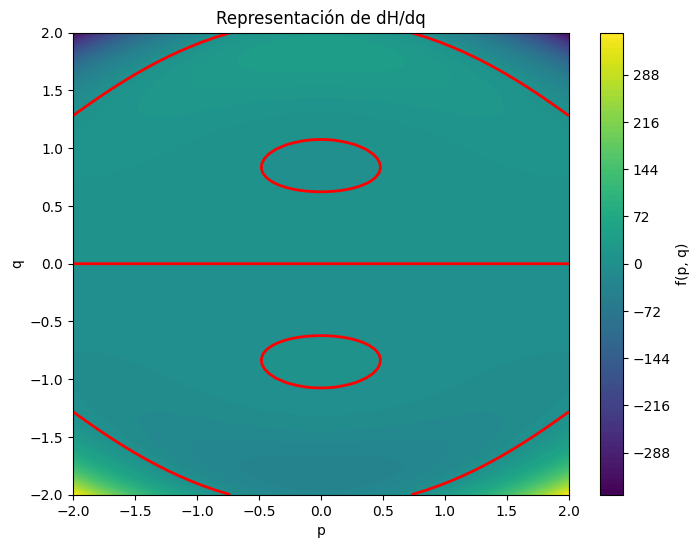

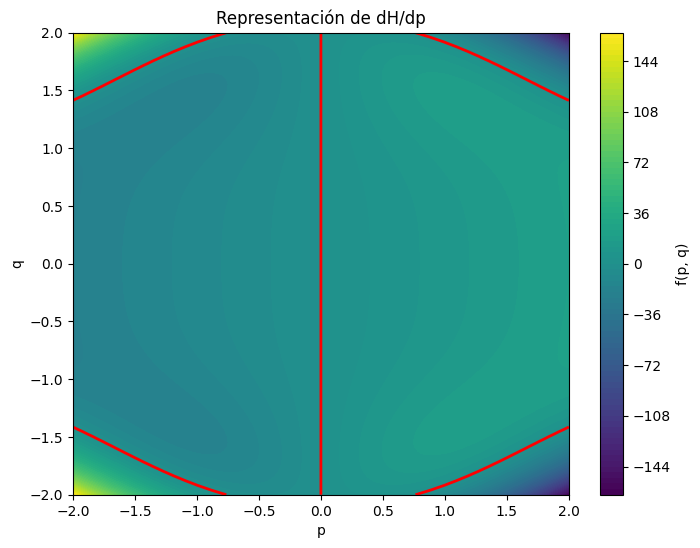

Uno de los dos puntos de silla se sitúa en [0, -0.6227732344377408 ] con precisión 1.1102230246251565e-16 en 10000 iteraciones
La energía en la que se sitúan las curvas de nivel que se cruzan es -9.49726 con 5 decimales de precisión


In [10]:
#Voy a plotear dH/dp y dH/dq:
from scipy.optimize import root_scalar

def plot_f_pq(f,name, p_range=(-2, 2), q_range=(-2, 2), grid_size=100):
    p = np.linspace(p_range[0], p_range[1], grid_size)
    q = np.linspace(q_range[0], q_range[1], grid_size)
    P, Q = np.meshgrid(p, q)
    F = f(P, Q)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(P, Q, F, levels=100, cmap='viridis')
    plt.colorbar(label='f(p, q)')
    plt.xlabel('p')
    plt.ylabel('q')
    plt.title(f'Representación de {name}')
    plt.contour(P, Q, F, levels=[0], colors='red', linewidths=2)
    plt.show()

N = 1500
J = N/2
h=   5
K = 3 * (N / 2) ** 3


plot_f_pq(lambda p, q: 2*q*(J*N**2*(p**2 + 2*q**2 - 4) + 2*K*q**2*(-p**2 - 2*q**2 + 4)*(p**2 + q**2 - 4) + N**3*h)/N**3,"dH/dq")
plot_f_pq(lambda p ,q: 2*p*(J*N**2*q**2- 2*K*q**4*(p**2 + q**2 - 4) + N**3*h)/N**3,"dH/dp")

def f(q):
    p=0
    return 2*q*(J*N**2*(p**2 + 2*q**2 - 4) + 2*K*q**2*(-p**2 - 2*q**2 + 4)*(p**2 + q**2 - 4) + N**3*h)/N**3

def biseccion(f,x1,x2,eps,N_max):
    if np.sign(f(x1))!=np.sign(f(x2)):
        N=0
        while abs(x1-x2)>eps and N<N_max:
            N+=1
            xp=0.5*(x1+x2)
            if np.sign(f(xp))==np.sign(f(x1)):
                x1=xp
            else:
                x2=xp
        return xp,N,abs(x1-x2)
    else:
        print("No existe raiz o el intervalo es otro")
        return


q_0,NN,eps=biseccion(f,-0.7,-0.5,10**-16,10000)
print(f"Uno de los dos puntos de silla se sitúa en [0, {q_0} ] con precisión {eps} en {NN} iteraciones")
print(f"La energía en la que se sitúan las curvas de nivel que se cruzan es {float(H(0,q_0)):.5f} con 5 decimales de precisión")

Como podemos ver efectivamente la enregía de esta curva de nivel está en torno a E $\approx$ -9.50. Sin embargo, este valor aproximado no nos sirve para representar esta situación. Necesitamos una gran cantidad de decimales significativos para poder resolver numéricamente esta evolución temporal. Se intentó de mejorar la precisión con mpmath, pero no solucionó el problema.

In [212]:
import mpmath
def f(q):
    p=0
    return 2*q*(J*N**2*(p**2 + 2*q**2 - 4) + 2*K*q**2*(-p**2 - 2*q**2 + 4)*(p**2 + q**2 - 4) + N**3*h)/N**3

q_0,NN,eps=biseccion(f,-0.65,-0.5,10**-20,20000)
print(f"Uno de los dos puntos de silla se sitúa en [0, {q_0} ] con precisión {eps} en {NN} iteraciones")
print(f"La energía en la que se sitúan las curvas de nivel que se cruzan es en torno a {float(H(0,q_0)):.5f}")
#q_0 = mpmath.mpf(q_0)

Uno de los dos puntos de silla se sitúa en [0, -0.6227732344377408 ] con precisión 1.1102230246251565e-16 en 20000 iteraciones
La energía en la que se sitúan las curvas de nivel que se cruzan es en torno a -9.49726


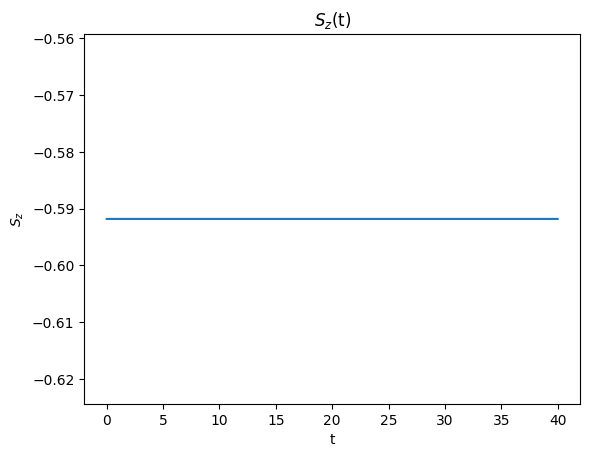

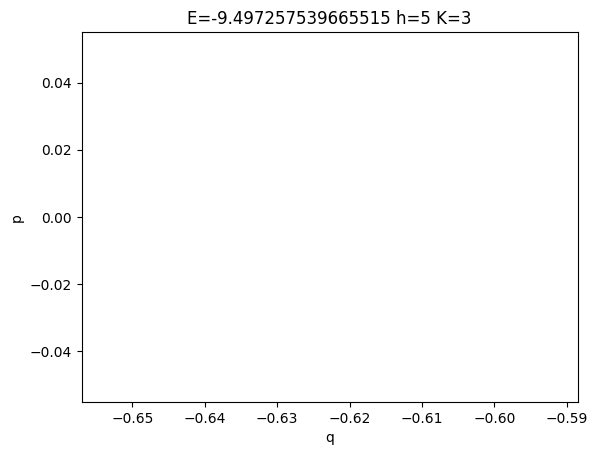

In [211]:
import numpy as np
import matplotlib.pyplot as plt
from mpmath import mp


n = 16 
mp.dps = n  # establecer la precisión
#q_0=q_00
# Función H usando mpmath 
def H(p, q):
    N = 1500
    J = N / 2
    h = 5
    K = 3 * (N / 2) ** 3
    p = mp.mpf(p)  # convertir p y q a tipos de mpmath
    q = mp.mpf(q)
    return -J * q ** 2 * (-p ** 2 - q ** 2 + 4) / N - K * q ** 4 * (-p ** 2 - q ** 2 + 4) ** 2 / N ** 3 - 2 * h * (-p ** 2 / 2 - q ** 2 / 2 + 1)

# Función S_z 
def S_z(p, q):
    p = mp.mpf(p)
    q = mp.mpf(q)
    return q * mp.sqrt(4 - q ** 2 - p ** 2) / 2

# Función de evolución temporal usando mpmath
def f(r, t):
    N = 1500
    J = N / 2
    h = 5
    K = 3 * (N / 2) ** 3
    p = r[0]
    q = r[1]
    fp = -(2 * q * (J * N ** 2 * (p ** 2 + 2 * q ** 2 - 4) + 2 * K * q ** 2 * (-p ** 2 - 2 * q ** 2 + 4) * (p ** 2 + q ** 2 - 4) + N ** 3 * h) / N ** 3)
    fq = 2 * p * (J * N ** 2 * q ** 2 - 2 * K * q ** 4 * (p ** 2 + q ** 2 - 4) + N ** 3 * h) / N ** 3
    return np.array([fp, fq], dtype=object)

# Condiciones iniciales
# un valor inicial de ejemplo
a = 0  # punto inicial
b = 40  # punto final
Np = 50000  # número de puntos
hp = (b - a) / Np  # tamaño del paso
tp = np.linspace(a, b, Np)  # inicializamos el tiempo
pp = []
qp = []
r = np.array([0, q_0], dtype=object)  # condiciones iniciales

# Resolver la ecuación diferencial
for t in tp:
    pp.append(float(r[0]))  # almacenar valores de p
    qp.append(float(r[1]))  # almacenar valores de q
    k1 = hp * f(r, t)
    k2 = hp * f(r + 0.5 * k1, t + 0.5 * hp)
    k3 = hp * f(r + 0.5 * k2, t + 0.5 * hp)
    k4 = hp * f(r + k3, t + hp)
    r += (k1 + 2 * k2 + 2 * k3 + k4) / 6

# Convertir pp y qp a mpmath antes de pasarlos a S_z
mp_pp = [mp.mpf(val) for val in pp]
mp_qp = [mp.mpf(val) for val in qp]

# Graficar S_z(t)
plt.plot(tp, [float(S_z(p, q)) for p, q in zip(mp_pp, mp_qp)])  # Convertir a float para graficar
plt.title("$S_{z}$(t)")
plt.xlabel("t")
plt.ylabel("$S_{z}$")
plt.show()

# Crear la malla de valores de P y Q
#p_values = np.linspace(-2, 2, 500)  # valores de P
#q_values = np.linspace(-2, 2, 500)  # valores de Q
#P, Q = np.meshgrid(p_values, q_values)

# Evaluar H en cada punto de la malla
#H_values = np.vectorize(lambda p, q: float(H(p, q)))(P, Q)

# Graficar el mapa de contorno
#plt.figure(figsize=(8, 6))
#plt.contourf(Q, P, H_values, levels=50, cmap='inferno')
#plt.colorbar()
plt.xlabel("q")
plt.ylabel("p")
plt.title(f"E={float(H(0, q_0))} h=5 K=3")
plt.plot(np.array(qp), np.array(pp))
plt.show()


OBSERVACIONES INTERESANTES:


·Solo podemos calcular q_0 con una precisión de 1e-16, para esta precisión el sistema se queda estático en el punto fijo inestable.

·Para precisiones menores a la precisión límite, a veces el sistema termina encerrado en un bucle con magnetización nula y otras con magnetización no nula. Esto ocurre pues el método utilizado para obtener el punto fijo (método de bisección), se va a acercando al punto fijo por ambos lados hasta llegar a uno que cumpla la condición de precisión, y este puede ser mínimamente mayor o menor, algo que marca su evolución posterior.

·Atendiendo únicamente a las evoluciones temporales de los casos paramagnéticos para poder comparar con la precisión, lo que observamos según aumentamos la precisión del punto fijo, es una menor cantidad de "oscilaciones" y un ligero aumento de las zonas planas de las oscilaciones y el tiempo inicial en el que se mantiene constante la magnetización hasta que empieza a oscilar. Con el caso de infinita precisión, que sería el caso límite, concluimos que el sistema se mantiene en este punto un tiempo infinito, lo que concuerda con la tesis inicial de que las evoluciones en el espacio de fases no se pueden cruzar y por lo tanto se tardaría un tiempo infinito en llegar a cualquiera de estos puntos fijos. Además, por lo observado en el comportamiento de las oscilaciones, cuando las hay, en un caso límite con la máxima precisión y un número infinito de decimales significativos, el sistema haría una primera media oscilación y se quedaría muy próximo en la magnetización del siguiente punto fijo tendiendo a este en un tiempo infinito.

Otro código para sacar el punto fijo problemático mediante el método de "hybrido" o "hybr", implementado en la función optimize.fsolve(), que es una combinación de varios métodos, incluido Newton-Raphson y otros como el método de Broyden.

Raíces encontradas: [np.float64(-2.110574986984146), np.float64(-1.0759306310282875), np.float64(-0.6227732344377407), np.float64(0.0), np.float64(0.6227732344377263), np.float64(1.0759306310282652), np.float64(2.110574986984146)]


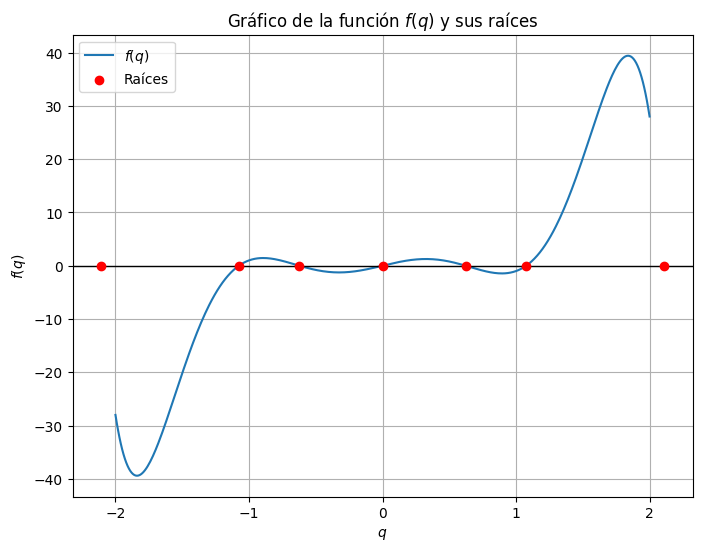

In [12]:

import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize



def f(q):
    h=   5
    N = 1500
    K = 3 * (N / 2) ** 3
    J = N/2
    p=0
    return 2*q*(J*N**2*(p**2 + 2*q**2 - 4) + 2*K*q**2*(-p**2 - 2*q**2 + 4)*(p**2 + q**2 - 4) + N**3*h)/N**3

# Método para encontrar la raíz usando fsolve de SciPy
def find_root(func, initial_guess):
    root = optimize.fsolve(func, initial_guess)  # Resolver la ecuación para encontrar la raíz
    return root

# Probar el método con varias suposiciones iniciales
initial_guesses = np.linspace(-2, 2, 20)  # Generar diferentes suposiciones iniciales en el intervalo [-2, 2]
roots = []

# Encontrar las raíces para cada suposición inicial
for guess in initial_guesses:
    root = find_root(f, guess)
    # Asegurarse de que no haya duplicados en las raíces encontradas
    if not any(np.isclose(root, r) for r in roots):
        roots.append(root[0])

# Imprimir las raíces encontradas
print("Raíces encontradas:", roots)

# Graficar la función f(q)
q_values = np.linspace(-2, 2, 400)  # Crear valores de q para graficar
f_values = f(q_values)  # Calcular los valores correspondientes de f(q)

# Graficar la función
plt.figure(figsize=(8, 6))
plt.plot(q_values, f_values, label=r'$f(q)$')
plt.axhline(0, color='black',linewidth=1)  # Línea horizontal en y=0 para ver donde cruza el eje
plt.scatter(roots, [f(r) for r in roots], color='red', label='Raíces', zorder=5)
plt.title(r'Gráfico de la función $f(q)$ y sus raíces')
plt.xlabel('$q$')
plt.ylabel('$f(q)$')
plt.legend()
plt.grid(True)
plt.show()
q_00=roots[2]

A continuación, hacemos la evolución temporal pero ahora no desde un punto fijo, sino desde uno de los extremos de la trayectoria para confirmar nuestra teoría del comportamiento del sistema. En este caso partimos del punto que se situa en el lado de q negativa:

In [39]:
#Primero obtenemos el punto [p,q] que tiene la misma energía que la trayectoria que pasa por el punto de silla pero que se sitúa en el extremo
#izquierdo (magnetización negativa)
def f(q):
    N = 1500
    J = N / 2
    h = 5
    K = 3 * (N / 2) ** 3
    p=0
    return -J * q ** 2 * (-p ** 2 - q ** 2 + 4) / N - K * q ** 4 * (-p ** 2 - q ** 2 + 4) ** 2 / N ** 3 - 2 * h * (-p ** 2 / 2 - q ** 2 / 2 + 1) -float(H(0,q_0))

def biseccion(f,x1,x2,eps,N_max):
    if np.sign(f(x1))!=np.sign(f(x2)):
        N=0
        while abs(x1-x2)>eps and N<N_max:
            N+=1
            xp=0.5*(x1+x2)
            if np.sign(f(xp))==np.sign(f(x1)):
                x1=xp
            else:
                x2=xp
        return xp,N,abs(x1-x2)
    else:
        print("No existe raiz o el intervalo es otro")
        return

float(H(0,q_0))

q_00,NN2,eps2=biseccion(f,-1.5,-0.7,10**-16,20000)
print(f"Uno de los dos puntos de silla se sitúa en [0, {q_00} ] con precisión {eps2} en {NN2} iteraciones")
#print(f"La energía en la que se sitúan las curvas de nivel que se cruzan es {float(H(0,q_0)):.5f} con 5 decimales de precisión")

Uno de los dos puntos de silla se sitúa en [0, -1.2564317443131148 ] con precisión 2.220446049250313e-16 en 20000 iteraciones


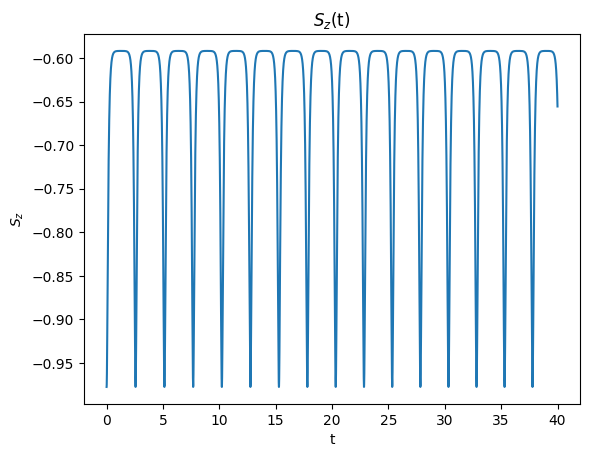

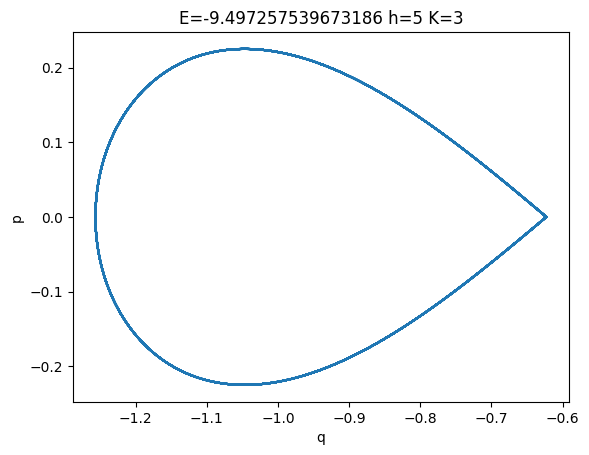

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from mpmath import mp

# Establecer la precisión deseada (por ejemplo, 50 cifras decimales)
n = 16 # número de cifras significativas
mp.dps = n  # establecer la precisión
# Función H usando mpmath para precisión arbitraria
def H(p, q):
    N = 1500
    J = N / 2
    h = 5
    K = 3 * (N / 2) ** 3
    p = mp.mpf(p)  # convertir p y q a tipos de mpmath
    q = mp.mpf(q)
    return -J * q ** 2 * (-p ** 2 - q ** 2 + 4) / N - K * q ** 4 * (-p ** 2 - q ** 2 + 4) ** 2 / N ** 3 - 2 * h * (-p ** 2 / 2 - q ** 2 / 2 + 1)
# Función S_z usando mpmath para precisión arbitraria
def S_z(p, q):
    p = mp.mpf(p)
    q = mp.mpf(q)
    return q * mp.sqrt(4 - q ** 2 - p ** 2) / 2

# Función de evolución temporal usando mpmath
def f(r, t):
    N = 1500
    J = N / 2
    h = 5
    K = 3 * (N / 2) ** 3
    p = r[0]
    q = r[1]
    fp = -(2 * q * (J * N ** 2 * (p ** 2 + 2 * q ** 2 - 4) + 2 * K * q ** 2 * (-p ** 2 - 2 * q ** 2 + 4) * (p ** 2 + q ** 2 - 4) + N ** 3 * h) / N ** 3)
    fq = 2 * p * (J * N ** 2 * q ** 2 - 2 * K * q ** 4 * (p ** 2 + q ** 2 - 4) + N ** 3 * h) / N ** 3
    return np.array([fp, fq], dtype=object)

# Condiciones iniciales
# un valor inicial de ejemplo
a = 0  # punto inicial
b = 40  # punto final
Np = 50000  # número de puntos
hp = (b - a) / Np  # tamaño del paso
tp = np.linspace(a, b, Np)  # inicializamos el tiempo
pp = []
qp = []
r = np.array([0, q_00], dtype=object)  # condiciones iniciales

# Resolver la ecuación diferencial
for t in tp:
    pp.append(float(r[0]))  # almacenar valores de p
    qp.append(float(r[1]))  # almacenar valores de q
    k1 = hp * f(r, t)
    k2 = hp * f(r + 0.5 * k1, t + 0.5 * hp)
    k3 = hp * f(r + 0.5 * k2, t + 0.5 * hp)
    k4 = hp * f(r + k3, t + hp)
    r += (k1 + 2 * k2 + 2 * k3 + k4) / 6

# Convertir pp y qp a mpmath antes de pasarlos a S_z
mp_pp = [mp.mpf(val) for val in pp]
mp_qp = [mp.mpf(val) for val in qp]

# Graficar S_z(t)
plt.plot(tp, [float(S_z(p, q)) for p, q in zip(mp_pp, mp_qp)])  # Convertir a float para graficar
plt.title("$S_{z}$(t)")
plt.xlabel("t")
plt.ylabel("$S_{z}$")
plt.show()

# Crear la malla de valores de P y Q
#p_values = np.linspace(-2, 2, 500)  # valores de P
#q_values = np.linspace(-2, 2, 500)  # valores de Q
#P, Q = np.meshgrid(p_values, q_values)

# Evaluar H en cada punto de la malla
#H_values = np.vectorize(lambda p, q: float(H(p, q)))(P, Q)

# Graficar el mapa de contorno
#plt.figure(figsize=(8, 6))
#plt.contourf(Q, P, H_values, levels=50, cmap='inferno')
#plt.colorbar()
plt.xlabel("q")
plt.ylabel("p")
plt.title(f"E={float(H(0, q_00))} h=5 K=3")
plt.plot(np.array(qp), np.array(pp))
plt.show()

Como se observa, según aumentamos la precisión de q_0, el tiempo en el que el sistema permanece en cerca del punto fijo en cada oscilación es mayor y se reduce tiempo entre oscilaciones. También se reducen el número de oscilaciones. En el caso límite con una precisión infinita se observaría un aumento de la magnetización hasta la correspondiente del punto fijo y una permanencia infinita en este valor.

# EVOLUCIONES TEMPORALES EN FUNCIÓN DE CONDICIONES INICIALES-CUÁNTICO

De nuevo, fijamos el hamiltoniano final que hemos utilizado hasta ahora con h=5 y K=3. Utilizamos los valores h_0 y K_0 que hemos considerado antes para escoger el estado fundamental del que partir, aplicamos el quench y dejamos al sistema evolucionar con el nuevo hamiltoniano. Lo que esperamos observar es lo argumentado anteriormente sobre la comparación entre la evolución temporal cuántica y clásica.

Para un $H_0$ con h=1.98 y K=0 accedemos al único estado posible, paramagnético, para una energía $E<E_{c1}$:

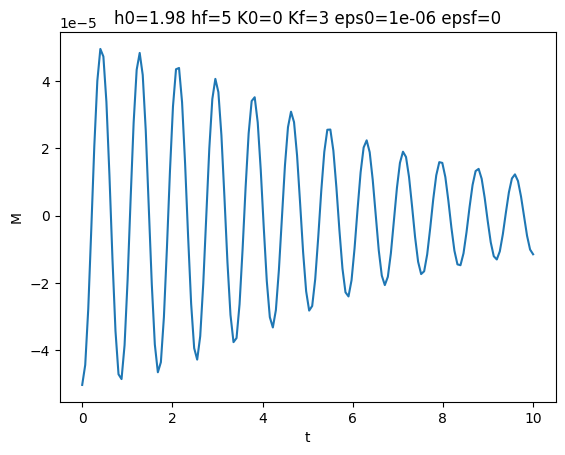

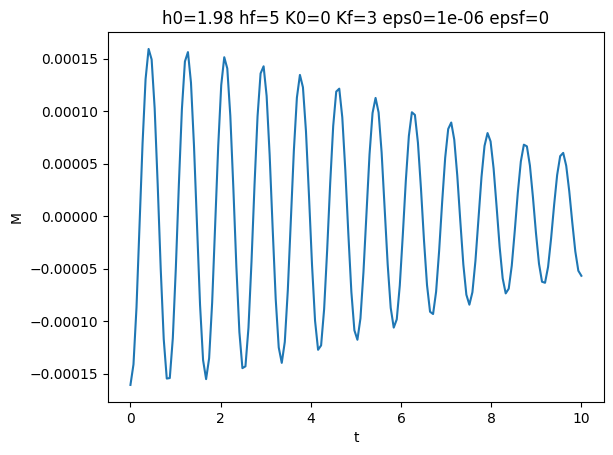

In [26]:
evolution_time(1.98, 5,0,3,1e-6, 0, 0, 10, 150, 1000)
evolution_time(1.98, 5,0,3,1e-6, 0, 0, 10, 150, 2000)

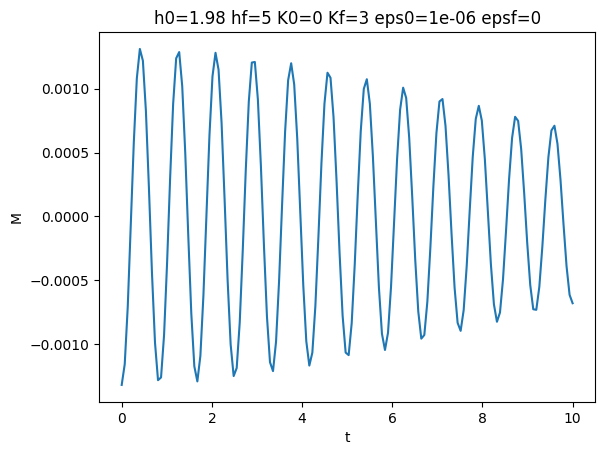

In [24]:
evolution_time(1.98, 5,0,3,1e-6, 0, 0, 10, 150, 4000)

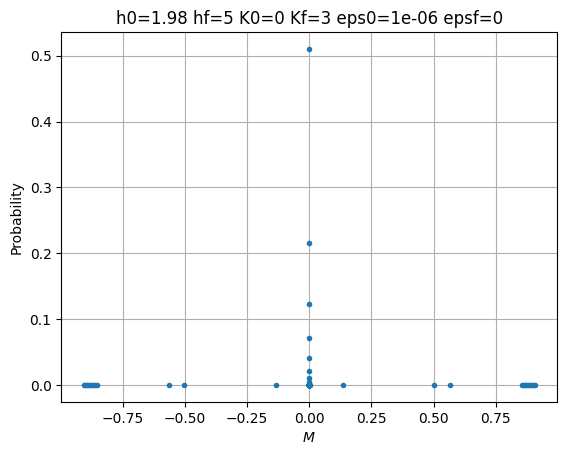

La máxima probabilidad se da para M = 4.705552048604087e-15
La máxima probabilidad se da para E_n = -10.0022838278812


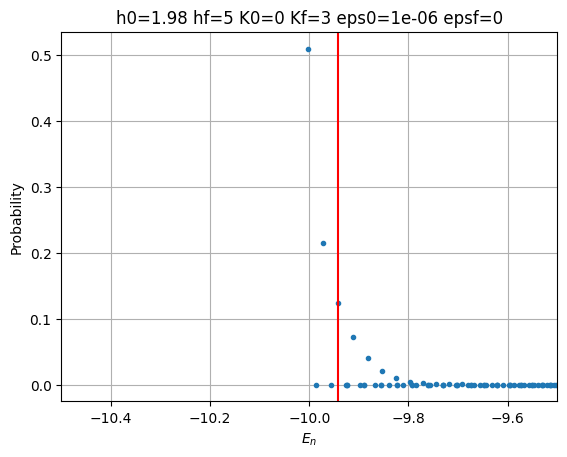

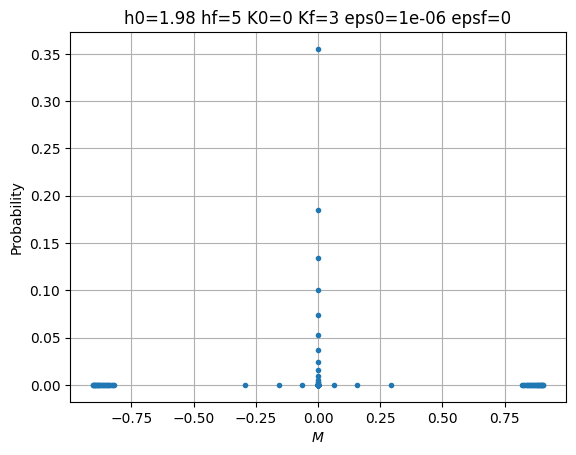

La máxima probabilidad se da para M = -6.110871554137428e-15
La máxima probabilidad se da para E_n = -10.00113443852642


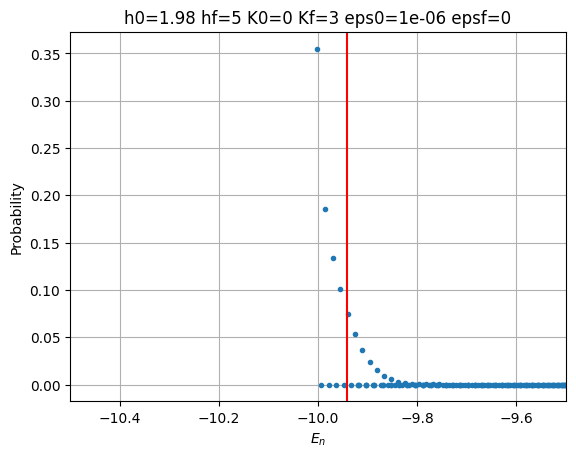

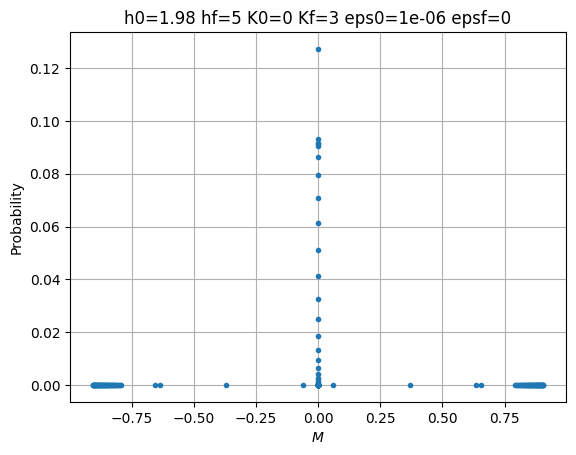

La máxima probabilidad se da para M = -4.88649079611858e-15
La máxima probabilidad se da para E_n = -10.000565360485972


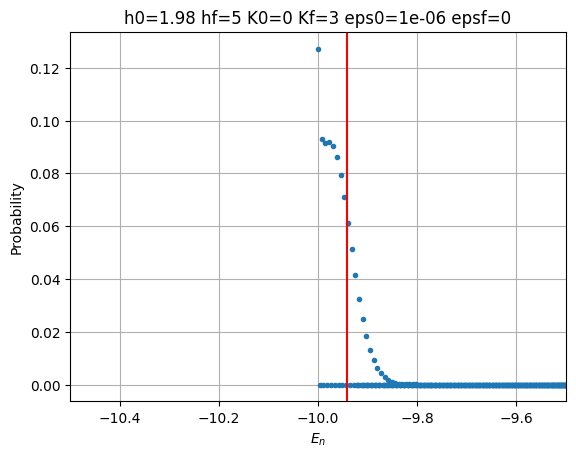

In [27]:
distribucion_energias(1000,1.98, 5,0,3,1e-6, 0)
plt.axvline(x=-9.942176, color='red')
plt.xlim([-10.5,-9.5])
plt.show()
distribucion_energias(2000,1.98, 5,0,3,1e-6, 0)
plt.axvline(x=-9.942176, color='red')
plt.xlim([-10.5,-9.5])
plt.show()
distribucion_energias(4000,1.98, 5,0,3,1e-6, 0)
plt.axvline(x=-9.942176, color='red')
plt.xlim([-10.5,-9.5])
plt.show()

En este caso, observamos algo que no nos había ocurrido antes. Para empezar, al comparar las evoluciones temporales, vemos que el valor inicial no coincide para ningún valor de N, lo que nos llevaría a pensar que hay algún error. Sin embargo, vemos que seún aumenta N el valor inicial de $<S_z>$ cada vez es mas cercano a la versión clásica. Esto se puede explicar razonablemente utilizando los primeros esquemas de M frente a $E_n$ donde se observa que para valores tan cercanos a la transición de segundo orden por el lado h<$h_c$, el número de autoestados con M $\neq$ 0 y el valor de su magnetización depende fuertemente del número de N para los valores que estamos utilizando para las simulaciones. Sin embargo, el valor de la magnetización media en el estado fundamental tiende al valor inicial de $<S_z>$ que observamos en la evolución clásica, como sí es coherente:

In [33]:
def diagrama_de_fases(h,K,N):
    s=1/2#Spin individual
    S=int(N*s)#Spin total
    Ms=np.arange(S, -S - 1, -1)
    Ms=Ms.astype(float)
    #Matriz S_z----------------
    S_z=np.diag(Ms)
    #Matriz S_+----------------

    def s_mas(m):
        return np.sqrt(S*(S+1)-m*(m+1))

    S_mas = np.zeros((2*S+1, 2*S+1))
    s_mas_vector= s_mas(np.arange(S-1, -S - 1, -1))

    for i in range(len(s_mas_vector)):
        S_mas[i, i + 1] = s_mas_vector[i]
    #Matriz S_- -------------    

    def s_menos(m):
        return np.sqrt(S*(S+1)-m*(m-1))

    S_menos = np.zeros((2*S+1, 2*S+1))
    s_menos_vector= s_menos(np.arange(S, -S, -1))
    for i in range(len(s_menos_vector)):
        S_menos[i+1, i] = s_menos_vector[i]
    #Matriz S_x

    S_x=1/2 * (S_mas + S_menos)
    J=1
    epsilon=10**(-6)
    H=-(4*J)/N * np.diag(Ms*Ms)-2*h*S_x-(16*K)/(N**3)*np.diag(Ms*Ms*Ms*Ms) + epsilon*S_z

    #Obtenemos las autoenergías diagonalizando la matriz:
    autoenergias, autovectores = diagonalizar_tridiagonal_simetrica(np.diag(H), np.diag(H, k=1))
    magn=[]
    for i in range(int(N+1)):
        magn.append((autovectores[:,i] @ (Ms*autovectores[:,i]).T)*1/(N/2))  
    #Representación del valor promedio de S_z frente a las energías obtenidas
    mt.plot(autoenergias/(N/2),np.array(magn),'.')
    mt.axhline(y=1,color='red',label="$S_{max}$")
    mt.axhline(y=-1,color='green',label="$S_{min}$")
    mt.xlabel("$E_{n}$")
    mt.ylabel("M")
    mt.title(f'h={h} K={K}')
    mt.legend()
    mt.grid()
    
    return 

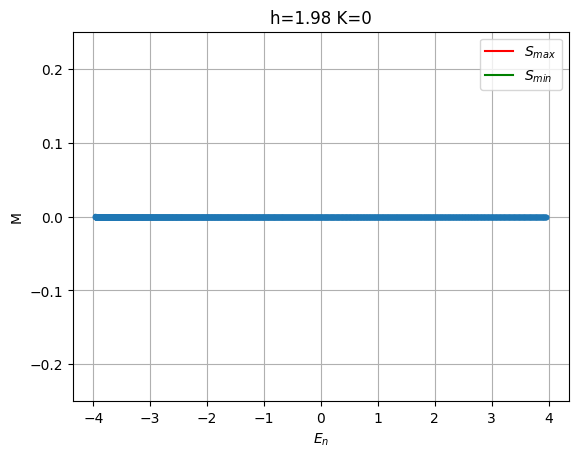

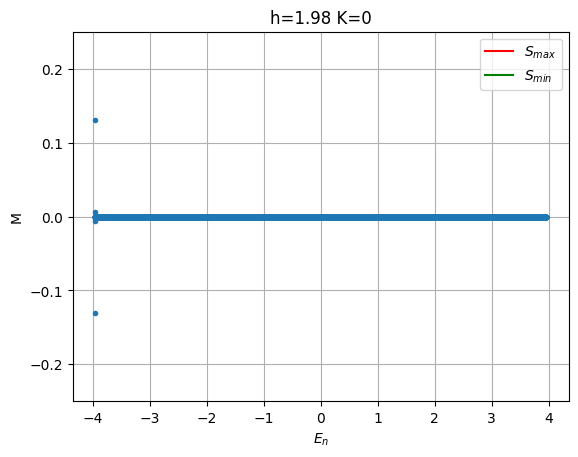

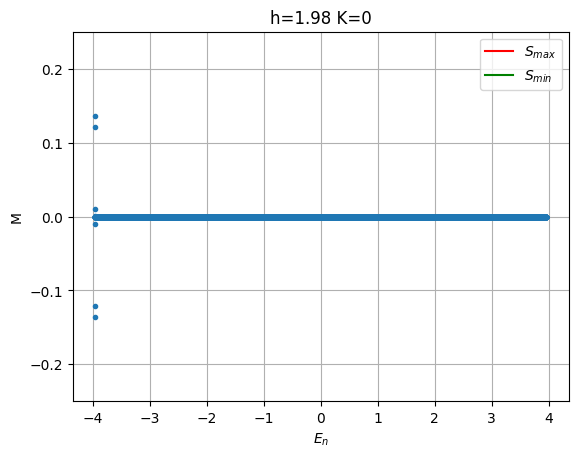

In [33]:
diagrama_de_fases(1.98,0,2000)
mt.ylim([-0.25,0.25])
mt.show()
diagrama_de_fases(1.98,0,10000)
mt.ylim([-0.25,0.25])
mt.show()
diagrama_de_fases(1.98,0,15000)
mt.ylim([-0.25,0.25])
mt.show()

Lo mismo ocurriría con la energía pico de la distribución de energía, que cada vez se acercaría más, como ya se puede ir viendo con N=4000, donde el ese medio pico que se encuentra en el mínimo de energía comienza a hacerse irregular, y a acercarse a valores de mayor energía y más cercanos al valor clásico.

Para un $H_0$ con h=0.05 y K=0 accedemos de nuevo al único estado posible, paramagnético, para una energía $E>E_{c2}$. En este caso como vamos a ver, al estar alejados de la trancisión de fase no vamos a tener este problema y el ajuste va a ser mucho mejor:

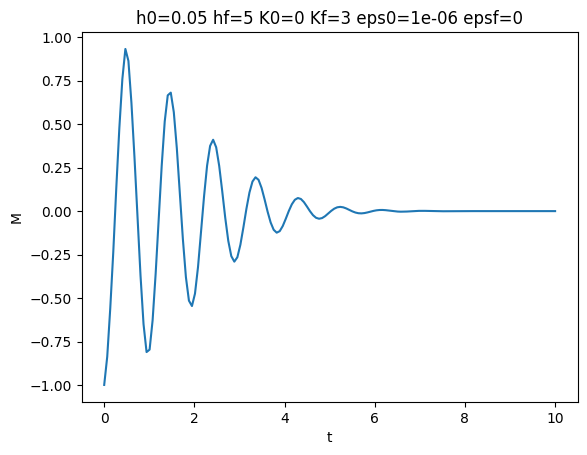

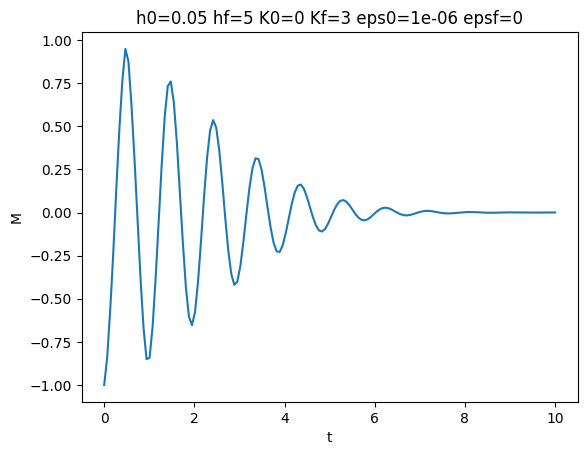

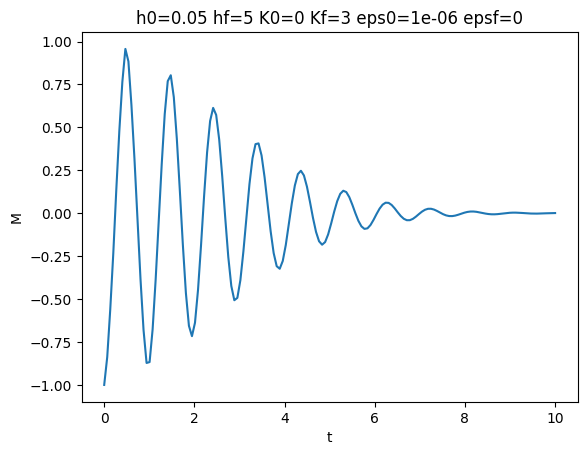

In [29]:
evolution_time(0.05, 5,0,3,1e-6, 0, 0, 10, 150, 1000)
evolution_time(0.05, 5,0,3,1e-6, 0, 0, 10, 150, 1500)
evolution_time(0.05, 5,0,3,1e-6, 0, 0, 10, 150, 2000)

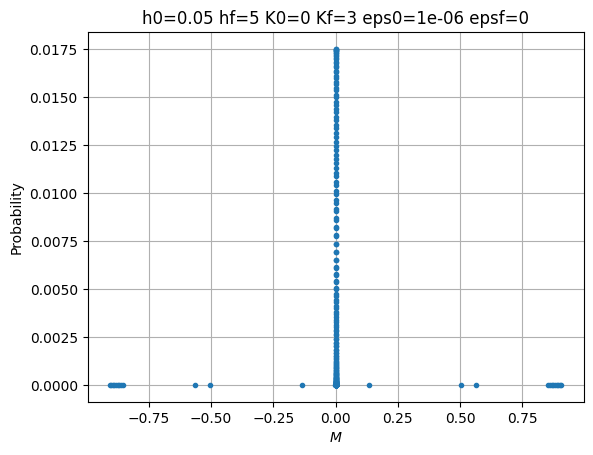

La máxima probabilidad se da para M = 4.4503067897494476e-14
La máxima probabilidad se da para E_n = -8.250722567581617


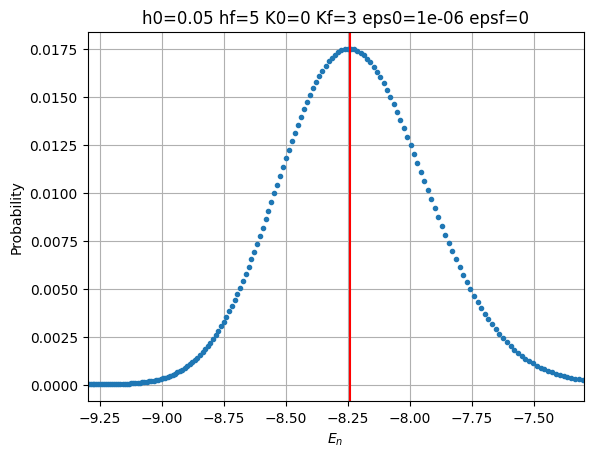

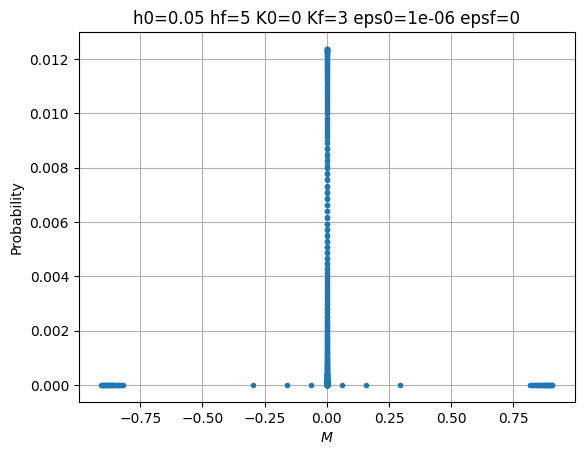

La máxima probabilidad se da para M = -3.202238474386832e-14
La máxima probabilidad se da para E_n = -8.245340525368304


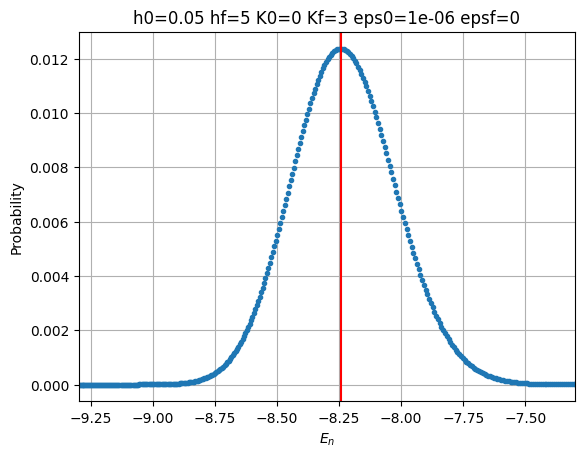

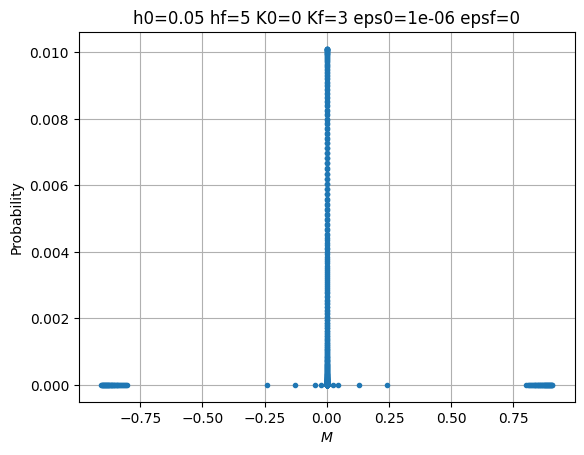

La máxima probabilidad se da para M = 3.381472879482317e-14
La máxima probabilidad se da para E_n = -8.243546473519157


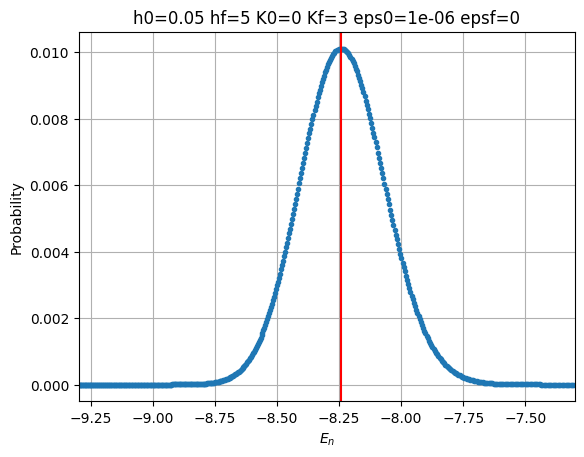

In [22]:
distribucion_energias(1000,0.05, 5,0,3,1e-6, 0)
plt.axvline(x=-8.241248, color='red')
plt.xlim([-9.3,-7.3])
plt.show()
distribucion_energias(2000,0.05, 5,0,3,1e-6, 0)
plt.axvline(x=-8.241248, color='red')
plt.xlim([-9.3,-7.3])
plt.show()
distribucion_energias(3000,0.05, 5,0,3,1e-6, 0)
plt.axvline(x=-8.241248, color='red')
plt.xlim([-9.3,-7.3])
plt.show()

En este caso como podemos ver, de nuevo la magnetización esperada $<S_z>$ según aumentamos N (aumenta el tamaño del sistema) su evolución se asemeja más a la clásica y la energía, que se puede aproximar a una gaussiana, cada vez se hace más estrecha en torno a la energía del sistema clásico.

Por último, intentamos reproducir el caso de la trayectoria crítica que se cruza sobre sí misma en el espacio de fases en el caso clásico.

In [51]:
import numpy as np
import matplotlib.pyplot as plt
#from mpmath import mp

#q0=-1.25643174431311477 #Sacado de arriba q_00
q0=q_00
N=4000
K=0

#Sacamos el S_z que da lugar ese q con p=0

def S_z(p, q):
    return q * np.sqrt(4 - q ** 2 - p ** 2) / 2

M0=S_z(0,q0)
print(M0)
#Ahora fijamos K=0 y vamos a buscar un valor de h que nos de esa magnetización

def Mf(h):
    s=1/2#Spin individual
    S=int(N*s)#Spin total
    Ms=np.arange(S, -S - 1, -1)
    Ms=Ms.astype(float)
    #Matriz S_z----------------
    S_z=np.diag(Ms)
    #Matriz S_+----------------

    def s_mas(m):
        return np.sqrt(S*(S+1)-m*(m+1))

    S_mas = np.zeros((2*S+1, 2*S+1))
    s_mas_vector= s_mas(np.arange(S-1, -S - 1, -1))

    for i in range(len(s_mas_vector)):
        S_mas[i, i + 1] = s_mas_vector[i]
    #Matriz S_- -------------    

    def s_menos(m):
        return np.sqrt(S*(S+1)-m*(m-1))

    S_menos = np.zeros((2*S+1, 2*S+1))
    s_menos_vector= s_menos(np.arange(S, -S, -1))
    for i in range(len(s_menos_vector)):
        S_menos[i+1, i] = s_menos_vector[i]
    #Matriz S_x

    S_x=1/2 * (S_mas + S_menos)
    J=1
    epsilon=10**(-6)
    H=-(4*J)/N * np.diag(Ms*Ms)-2*h*S_x-(16*K)/(N**3)*np.diag(Ms*Ms*Ms*Ms) + epsilon*S_z

    #Obtenemos las autoenergías diagonalizando la matriz:
    autoenergias, autovectores = diagonalizar_tridiagonal_simetrica(np.diag(H), np.diag(H, k=1))
    M=autovectores[:,0] @ (Ms*autovectores[:,0]).T*1/(N/2)
    return -np.abs(M)

def Mfnula(h):
    return Mf(h)-M0

def biseccion(f,x1,x2,eps,N_max):
    if np.sign(f(x1))!=np.sign(f(x2)):
        N=0
        while abs(x1-x2)>eps and N<N_max:
            N+=1
            xp=0.5*(x1+x2)
            if np.sign(f(xp))==np.sign(f(x1)):
                x1=xp
            else:
                x2=xp
        return xp,N,abs(x1-x2)
    else:
        print("No existe raiz o el intervalo es otro")
        return

h0,NN,eps3=biseccion(Mfnula,0.3,0.5,10**-16,50)
print(f"{h0} con precisión {eps3} en {NN} iteraciones")
Mfnulav=np.vectorize(Mfnula)
Mfv=np.vectorize(Mf)

-0.9775530048580409
0.4212710032795302 con precisión 1.6653345369377348e-16 en 50 iteraciones


In [ ]:
#N=1500 --> 0.4210899353027344 con precisión 7.629394531138978e-07 en 18 iteraciones
#N=1500 -->  0.42109037162736074 con precisión 9.313222415485711e-11 en 31 iteraciones
#N=1500 -->  0.4210903716910592 con precisión 1.6653345369377348e-16 en 50 iteraciones
# || 0.42109037169105923 con precisión 5.551115123125783e-17 en 100 iteraciones

#N=2000 --> 0.4211626249738478 con precisión 5.551115123125783e-17 en 150 iteraciones

#N=2500 --> 0.4212059765290365 con precisión 1.6653345369377348e-16 en 50 iteraciones

#N=3000 --> 0.42123487722128633 con precisión 1.8626450382086546e-10 en 30 iteraciones

#N=4000 --> 0.4212710032795302 con precisión 1.6653345369377348e-16 en 50 iteraciones



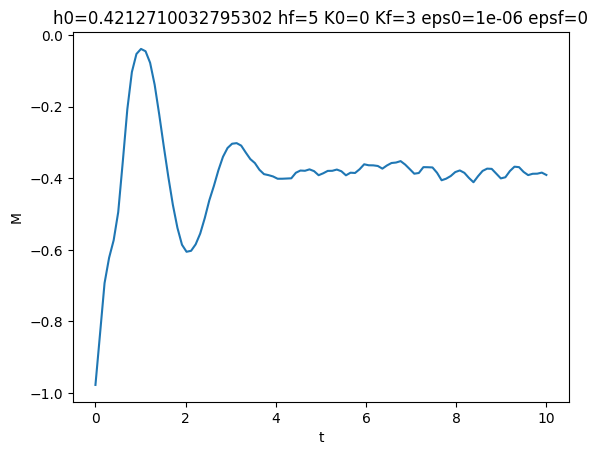

In [6]:
evolution_time(0.4212710032795302, 5,0,3,1e-6, 0, 0, 10, 100, 1500)

Tratamos de estudiar las distribuciones energéticas y de magnetización para poder trabajar con $N$'s más altos

N=1500


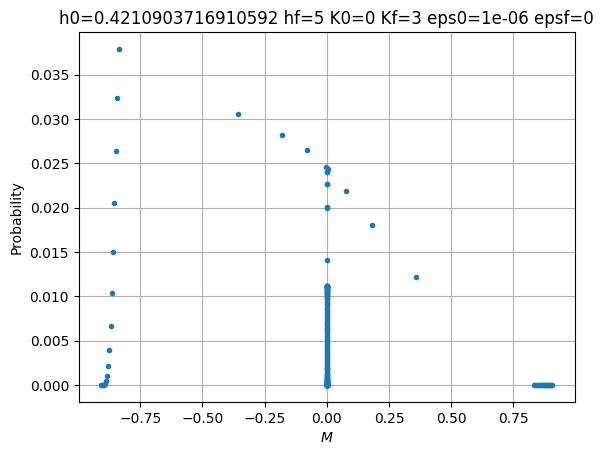

La máxima probabilidad se da para M = -0.8349277187457104
La máxima probabilidad se da para E_n = -9.618106079356476


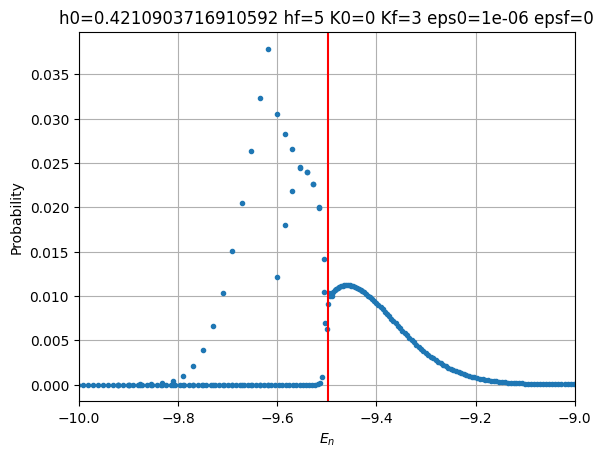

In [48]:
print("N=1500")
distribucion_energias(1500,0.4210903716910592, 5,0,3,1e-6, 0)
plt.axvline(x=-9.49725, color='red')
plt.xlim([-10,-9])
plt.show()

N=2500


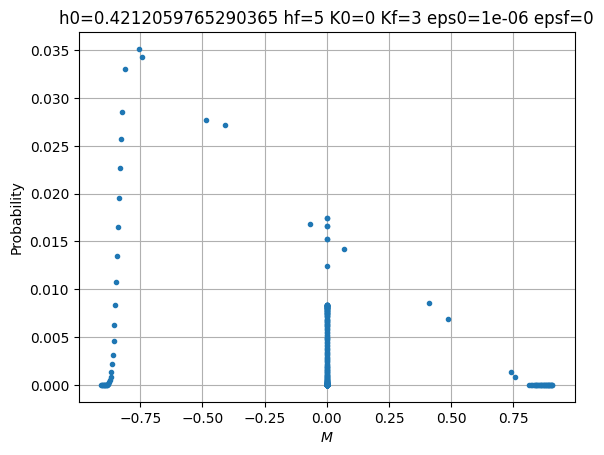

La máxima probabilidad se da para M = -0.7565380492547612
La máxima probabilidad se da para E_n = -9.54113209060512


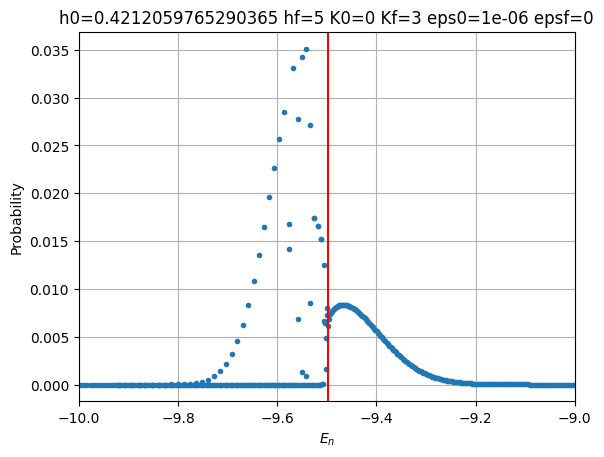

In [58]:
print("N=2500")
distribucion_energias(2500,0.4212059765290365, 5,0,3,1e-6, 0)
plt.axvline(x=-9.49725, color='red')
plt.xlim([-10,-9])
plt.show()

N=3000


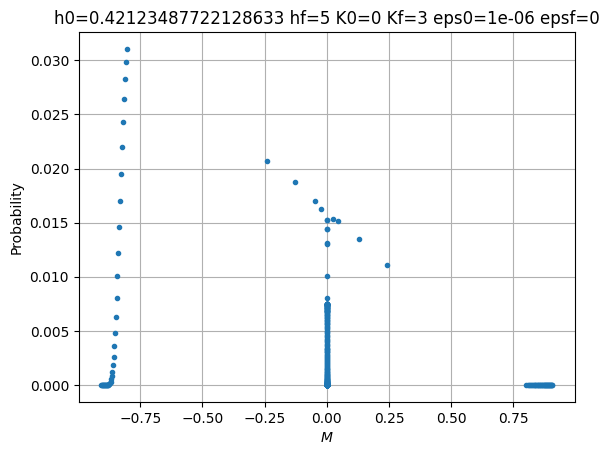

La máxima probabilidad se da para M = -0.8027821176116448
La máxima probabilidad se da para E_n = -9.551950102069723


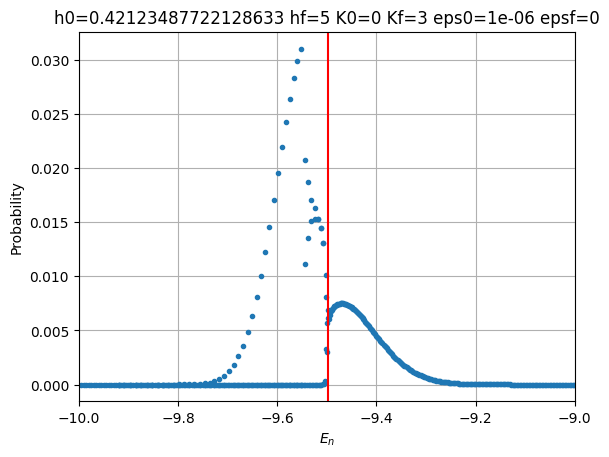

In [50]:
print("N=3000")
distribucion_energias(3000,0.42123487722128633, 5,0,3,1e-6, 0)
plt.axvline(x=-9.49725, color='red')
plt.xlim([-10,-9])
plt.show()

N=4000


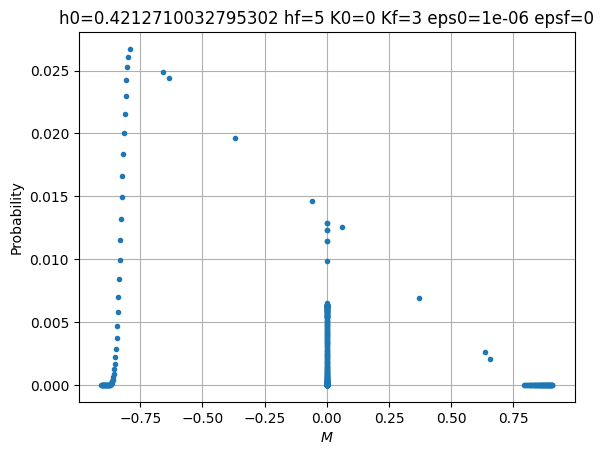

La máxima probabilidad se da para M = -0.7933404768040057
La máxima probabilidad se da para E_n = -9.538796927415822


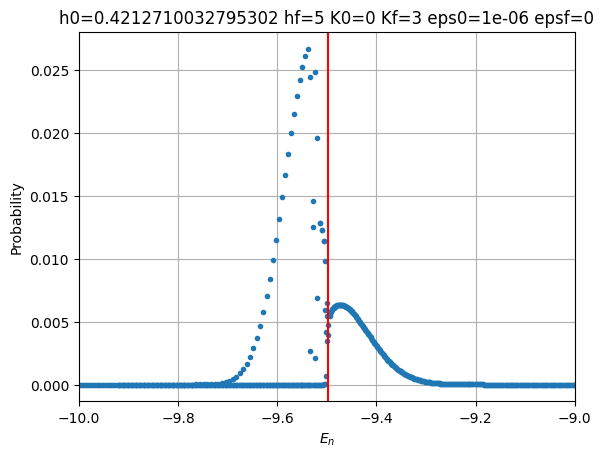

In [59]:
print("N=4000")
distribucion_energias(4000,0.4212710032795302, 5,0,3,1e-6, 0)
plt.axvline(x=-9.49725, color='red')
plt.xlim([-10,-9])
plt.show()

# Datos Mathematica para curva crítica

A continuación, mostramos los cálculos realizados para la versión clásica del sistema con Mathematica con un número de cifras significativas para los cálculos:

In [8]:
archivo = "critico.txt"  # Reemplaza con la ruta de tu archivo
datos = np.loadtxt(archivo)

# Separar las columnas en vectores distintos
t1, q1, p1, dist1 = datos.T  # Transpone para obtener columnas como vectores


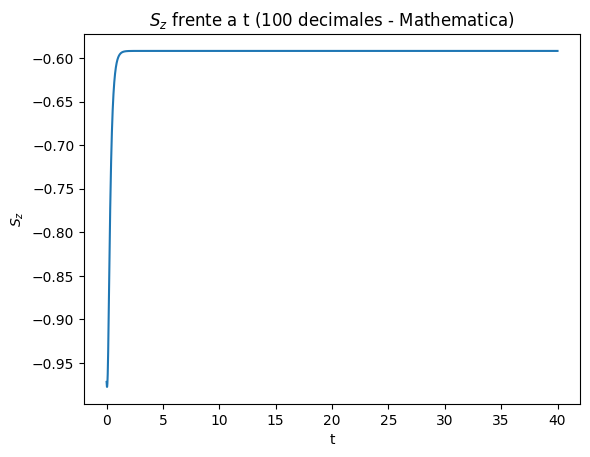

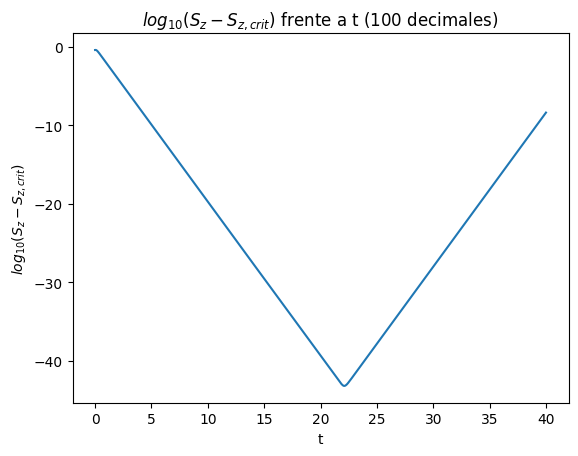

In [12]:
import matplotlib.pyplot as plt
def S_z(q):
    p=0
    return q * np.sqrt(4 - q ** 2 - p ** 2) / 2
    
plt.plot(t1,-S_z(q1))
plt.title("$S_{z}$ frente a t (100 decimales - Mathematica)")
plt.xlabel("t")
plt.ylabel("$S_{z}$")
plt.show()

plt.plot(t1,dist1)
plt.title("$log_{10}(S_{z}-S_{z,crit})$ frente a t (100 decimales)")
plt.xlabel("t")
plt.ylabel("$log_{10}(S_{z}-S_{z,crit})$")
plt.show()

Cálculo con 100 cifras significativas:

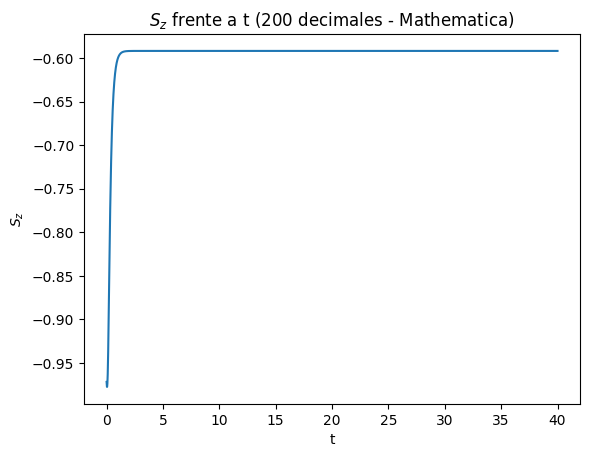

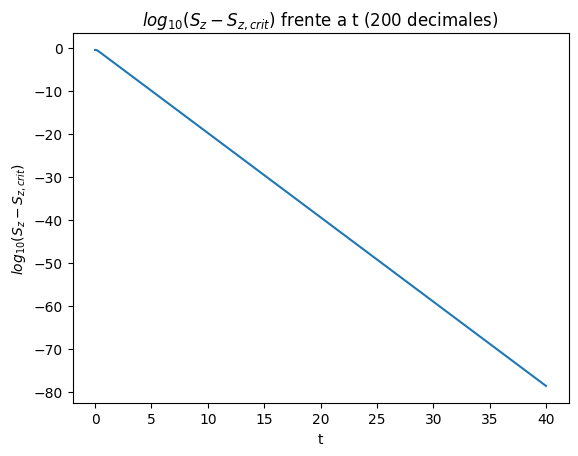

In [13]:
archivo = "critico2.txt"  # Reemplaza con la ruta de tu archivo
datos = np.loadtxt(archivo)

# Separar las columnas en vectores distintos
t2, q2, p2, dist2 = datos.T  # Transpone para obtener columnas como vectores

plt.plot(t2,-S_z(q2))
plt.title("$S_{z}$ frente a t (200 decimales - Mathematica)")
plt.xlabel("t")
plt.ylabel("$S_{z}$")
plt.show()
plt.plot(t2,dist2)
plt.title("$log_{10}(S_{z}-S_{z,crit})$ frente a t (200 decimales)")
plt.xlabel("t")
plt.ylabel("$log_{10}(S_{z}-S_{z,crit})$")
plt.show()

Como podemos ver en el caso con 100 y 200 cifras significativas se observa en $S_z$ frente a t lo que se predijo y a lo que tendía nuestra versión simulada con python. Esto es, el sistema se acerca hacia el punto fijo pero tarda un tiempo infinito en alcanzarlo.

Lo que observamos en la segunda gráfica es como se comporta la distancia a la magnetización del punto de silla del sistema. Como podemos ver para 100 cifras significativasa partir de 20 segundos aprox el error vuelve a aumentar. Sin embargo, con 200 el error logarítmico sigue disminuyendo con el tiempo linealmente, es decir, el error seguiría disminuyendo exponencialmente. Esto nos hace pensar, de nuevo, que para una cifra infinita de cifras significativas el sistema se comportaría como en las gráficas.

En resumen: lo que ocurre en el primer caso es que la precisión no es suficiente (¡a pesar de trabajar con 100 cifras significativas!) para llegar a tiempos tan grandes; los errores de redondeo se comportan como una perturbación, y la trayectoria se inestabiliza y se aleja del punto de corte. En critico2.dat la precisión es suficiente para llegar hasta t=40, pero ese rebote en el error logarítmico se observaría a tiempos más largos.